In [ ]:
!apt-get install r-base
!R -e 'install.packages("IRkernel")'
!R -e 'IRkernel::installspec()'

In [ ]:
install.packages("deSolve", repos = "http://cran.us.r-project.org")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
flu_1=function(t,u,parms){
#
# Function flu_1 computes the t derivative vector
# of the S,V,E,I,R vectors
#
# One vector to five vectors
S=rep(0,nx);V=rep(0,nx);
E=rep(0,nx);I=rep(0,nx);
R=rep(0,nx);
for(i in 1:nx){
S[i]=u[i];
V[i]=u[i+nx];
E[i]=u[i+2*nx];
I[i]=u[i+3*nx];
R[i]=u[i+4*nx];
}
#
# Boundary conditions
Sx=dss004(xl,xu,nx,S);
Vx=dss004(xl,xu,nx,V);
Ex=dss004(xl,xu,nx,E);
Ix=dss004(xl,xu,nx,I);
Rx=dss004(xl,xu,nx,R);
Sx[1]=0;Sx[nx]=0;
Vx[1]=0;Vx[nx]=0;
Ex[1]=0;Ex[nx]=0;
Ix[1]=0;Ix[nx]=0;
Rx[1]=0;Rx[nx]=0;
nl=2;nu=2;
#
# Sxx to Rxx
Sxx=dss044(xl,xu,nx,S,Sx,nl,nu);
Vxx=dss044(xl,xu,nx,V,Vx,nl,nu);
Exx=dss044(xl,xu,nx,E,Ex,nl,nu);
Ixx=dss044(xl,xu,nx,I,Ix,nl,nu);
Rxx=dss044(xl,xu,nx,R,Rx,nl,nu);
#
# PDEs
b=beta;be=betae;bi=betai;bv=betav;
a=alpha;p=phi;d=delta;t=theta;k=kappa;
s=sigma;g=gamma;
St=rep(0,nx);Vt=rep(0,nx);
Et=rep(0,nx);It=rep(0,nx);
Rt=rep(0,nx);
for(i in 1:nx){
ES=E[i]*S[i];
IS=I[i]*S[i];
EV=E[i]*V[i];
IV=I[i]*V[i];
IE=I[i]*E[i];
IR=I[i]*R[i];
St[i]=-b*be*ES-b*bi*IS+a*IS-p*S[i]-r*S[i]
+d*R[i]+t*V[i]+r+d1*Sxx[i];
Vt[i]=-b*be*bv*EV-b*bi*bv*IV+a*IV-r*V[i]
-t*V[i]+p*S[i]+d2*Vxx[i];
Et[i]=b*be*ES+b*bi*IS+b*be*bv*EV+b*bi*bv*IV
+a*IE-(r+k+s)*E[i]+d3*Exx[i];
It[i]=s*E[i]-(r+a+g)*I[i]+a*I[i]^2+d4*Ixx[i];
Rt[i]=k*E[i]+g*I[i]-r*R[i]-d*R[i]+a*IR+d5*Rxx[i];
}
#
# Five vectors to one vector
ut=rep(0,5*nx);
for(i in 1:nx){
ut[i] =St[i];
ut[i+nx] =Vt[i];
ut[i+2*nx]=Et[i];
ut[i+3*nx]=It[i];
ut[i+4*nx]=Rt[i];
}
#
# Increment calls to flu_1
ncall <<- ncall+1;
#
# Return derivative vector
return(list(c(ut)));
}


In [ ]:
dss004 <- function(xl, xu, n, u) {
  # Compute the spatial increment
  dx <- (xu - xl) / (n - 1)
  r4fdx <- 1 / (12 * dx)
  nm2 <- n - 2

  # Initialize the output array
  ux <- numeric(n)

  # Equation (1) for the left boundary
  ux[1] <- r4fdx * (-25 * u[1] + 48 * u[2] - 36 * u[3] + 16 * u[4] - 3 * u[5])

  # Equation (2) for the second point
  ux[2] <- r4fdx * (-3 * u[1] - 10 * u[2] + 18 * u[3] - 6 * u[4] + 1 * u[5])

  # Equation (3) for interior points
  for (i in 3:nm2) {
    ux[i] <- r4fdx * (1 * u[i-2] - 8 * u[i-1] + 0 * u[i] + 8 * u[i+1] - 1 * u[i+2])
  }

  # Equation (4) for the second-to-last point
  ux[n-1] <- r4fdx * (-1 * u[n-4] + 6 * u[n-3] - 18 * u[n-2] + 10 * u[n-1] + 3 * u[n])

  # Equation (5) for the right boundary
  ux[n] <- r4fdx * (3 * u[n-4] - 16 * u[n-3] + 36 * u[n-2] - 48 * u[n-1] + 25 * u[n])

  return(ux)
}

In [ ]:
dss044 <- function(xl, xu, n, u, ux, nl, nu) {
  # Compute the spatial increment
  dx <- (xu - xl) / (n - 1)
  r12dxs <- 1 / (12 * dx^2)

  # Initialize the output array
  uxx <- numeric(n)

  # uxx at the left boundary
  if (nl == 1) {
    # Dirichlet boundary condition (equation 53)
    uxx[1] <- r12dxs * (
      45.0 * u[1] - 154.0 * u[2] + 214.0 * u[3] -
      156.0 * u[4] + 61.0 * u[5] - 10.0 * u[6]
    )
  } else if (nl == 2) {
    # Neumann boundary condition (equation 36)
    uxx[1] <- r12dxs * (
      (-415.0 / 6.0) * u[1] + 96.0 * u[2] - 36.0 * u[3] +
      (32.0 / 3.0) * u[4] - (3.0 / 2.0) * u[5] - 50.0 * ux[1] * dx
    )
  }

  # uxx at the right boundary
  if (nu == 1) {
    # Dirichlet boundary condition (equation 54)
    uxx[n] <- r12dxs * (
      45.0 * u[n] - 154.0 * u[n - 1] + 214.0 * u[n - 2] -
      156.0 * u[n - 3] + 61.0 * u[n - 4] - 10.0 * u[n - 5]
    )
  } else if (nu == 2) {
    # Neumann boundary condition (equation 37)
    uxx[n] <- r12dxs * (
      (-415.0 / 6.0) * u[n] + 96.0 * u[n - 1] - 36.0 * u[n - 2] +
      (32.0 / 3.0) * u[n - 3] - (3.0 / 2.0) * u[n - 4] + 50.0 * ux[n] * dx
    )
  }

  # uxx at the interior grid points
  # i = 2 (equation 23)
  uxx[2] <- r12dxs * (
    10.0 * u[1] - 15.0 * u[2] - 4.0 * u[3] +
    14.0 * u[4] - 6.0 * u[5] + 1.0 * u[6]
  )

  # i = n-1 (equation 24)
  uxx[n - 1] <- r12dxs * (
    10.0 * u[n] - 15.0 * u[n - 1] - 4.0 * u[n - 2] +
    14.0 * u[n - 3] - 6.0 * u[n - 4] + 1.0 * u[n - 5]
  )

  # i = 3, 4, ..., n-2 (equation 9)
  for (i in 3:(n - 2)) {
    uxx[i] <- r12dxs * (
      -1.0 * u[i - 2] + 16.0 * u[i - 1] - 30.0 * u[i] +
      16.0 * u[i + 1] - 1.0 * u[i + 2]
    )
  }

  return(uxx)
}



 betav =  0.900 phi =  0.050


[1] 11

[1] 306



 t x S(x,t)
V(x,t)
 E(x,t) I(x,t)
R(x,t)
    0.0  -3.00     0.00872     0.00101
       0.00000     0.00000     0.00000
    0.0  -2.90     0.01178     0.00137
       0.00000     0.00001     0.00000
    0.0  -2.80     0.01575     0.00183
       0.00000     0.00002     0.00000
    0.0  -2.70     0.02085     0.00242
       0.00000     0.00003     0.00000
    0.0  -2.60     0.02733     0.00318
       0.00000     0.00005     0.00000
    0.0  -2.50     0.03545     0.00412
       0.00000     0.00008     0.00000
    0.0  -2.40     0.04552     0.00529
       0.00000     0.00013     0.00000
    0.0  -2.30     0.05786     0.00673
       0.00000     0.00020     0.00000
    0.0  -2.20     0.07279     0.00846
       0.00000     0.00032     0.00000
    0.0  -2.10     0.09064     0.01054
       0.00000     0.00049     0.00000
    0.0  -2.00     0.11173     0.01299
       0.00000     0.00073     0.00000
    0.0  -1.90     0.13633     0.01585
       0.00000     0.00108     0.00000
    0.0  -1.80     0.

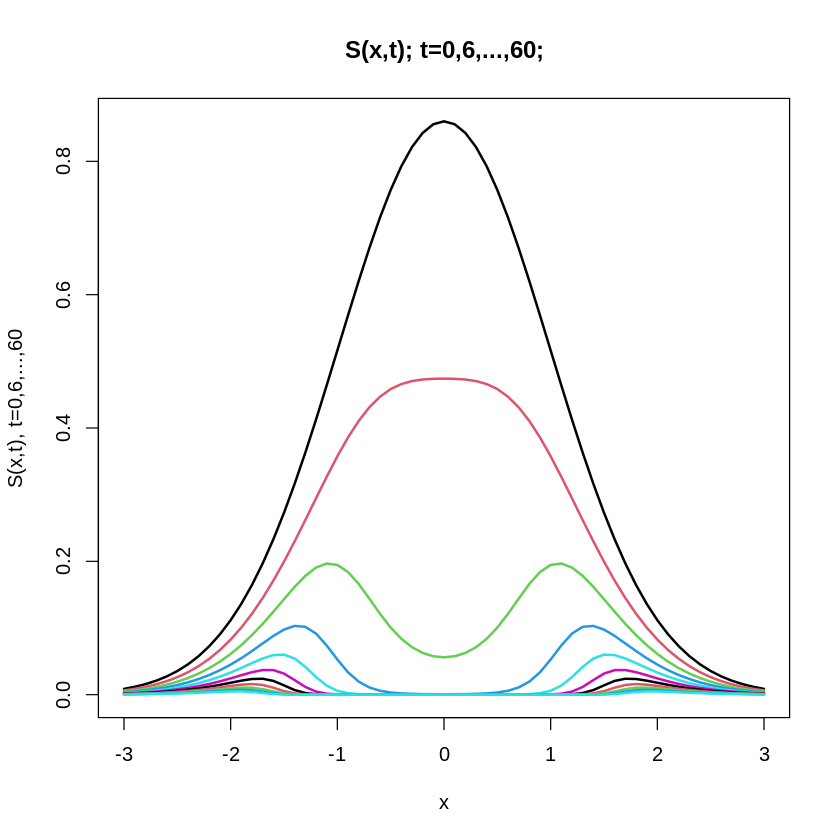

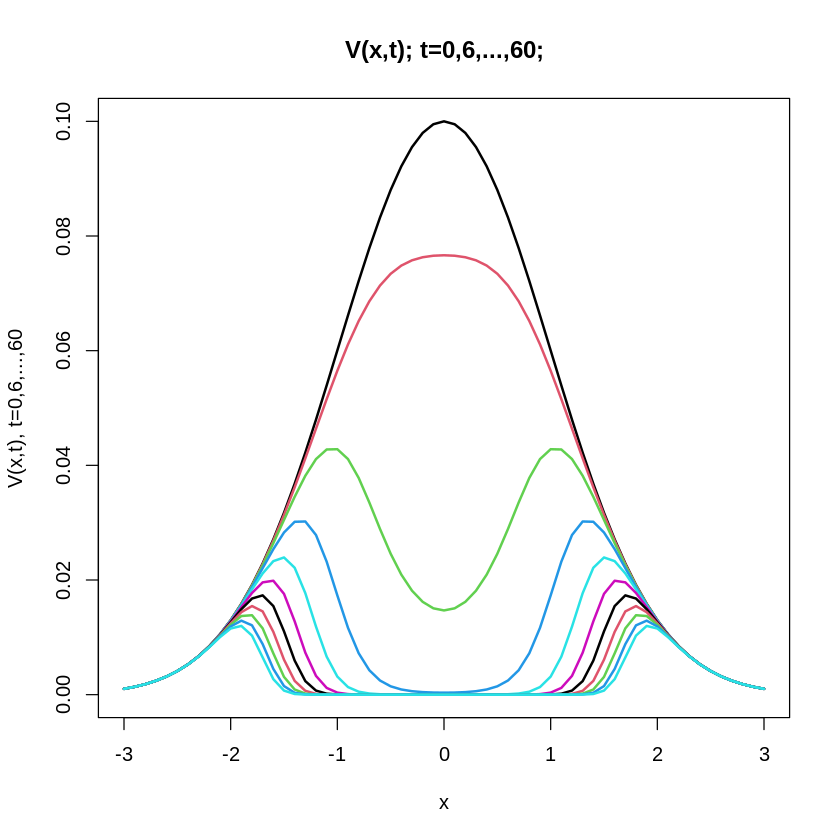

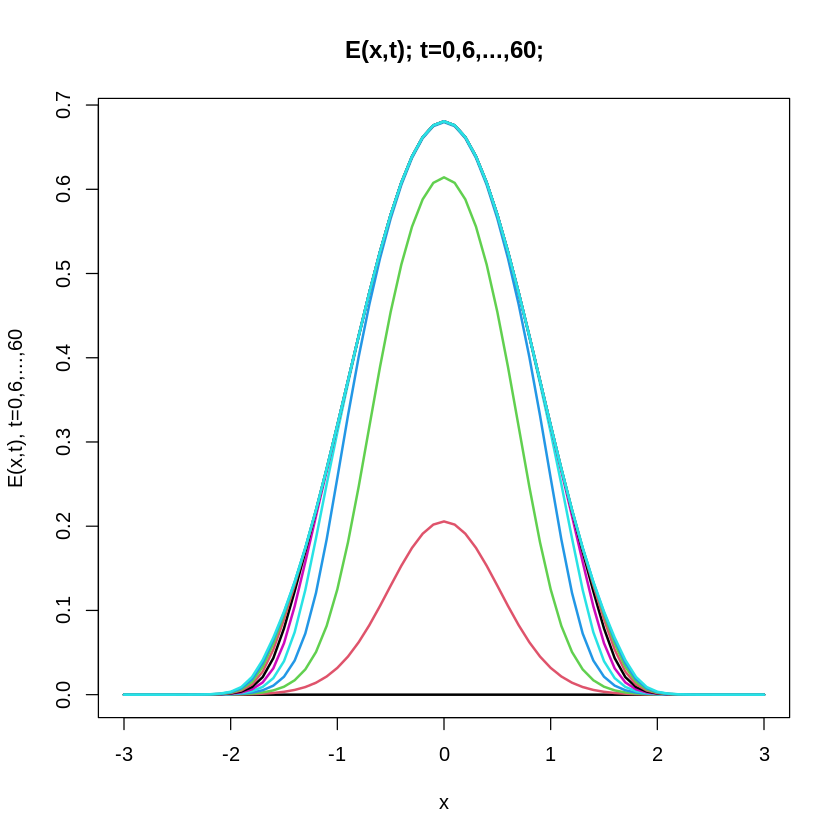

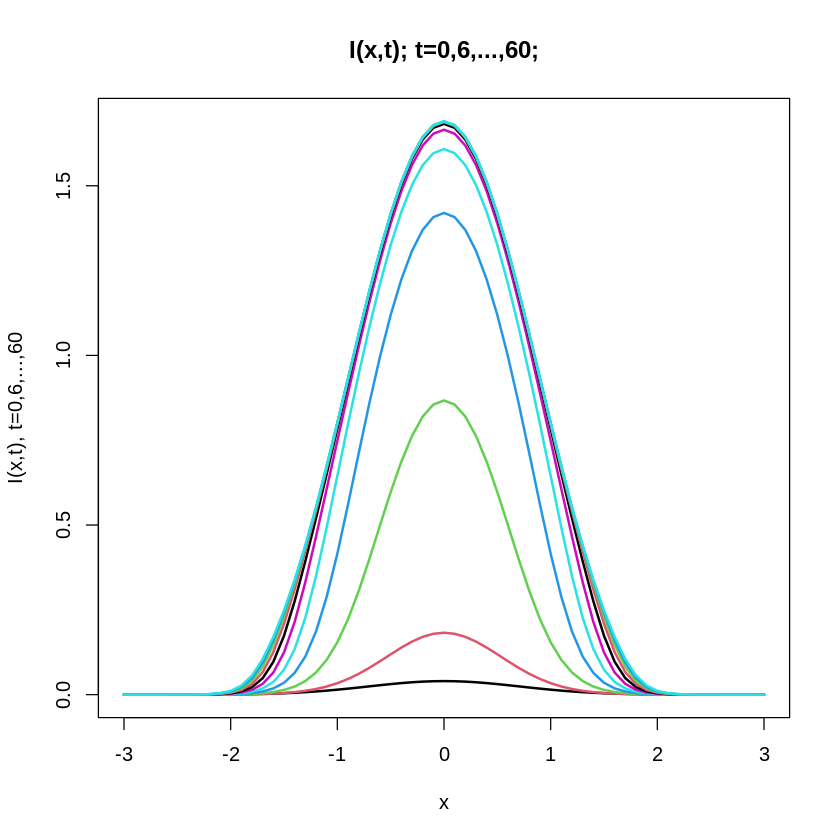

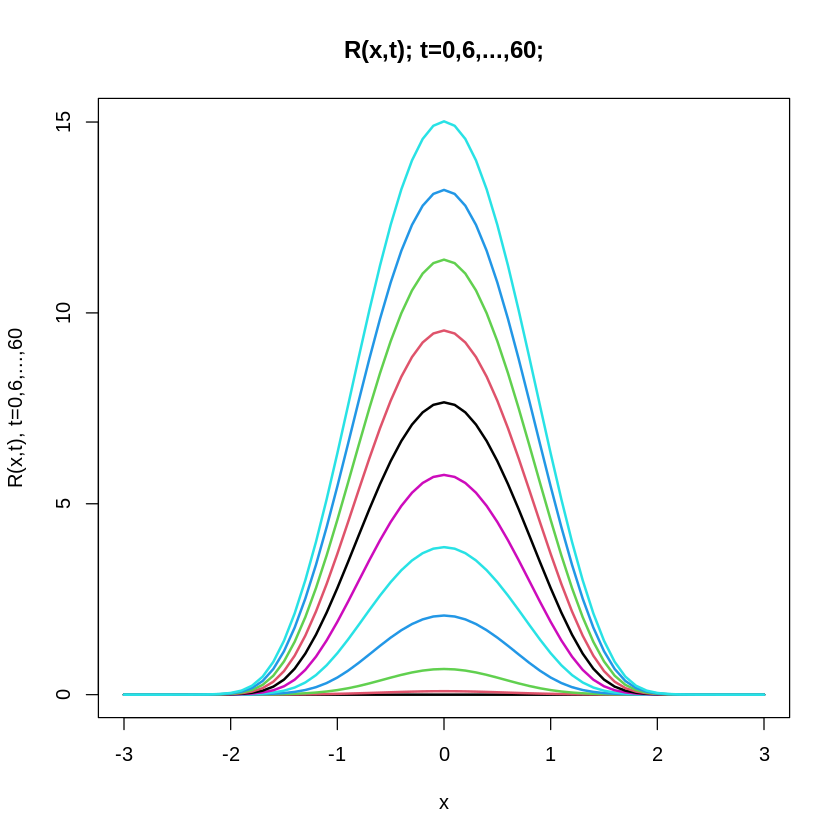

In [ ]:
# Access ODE integrator
library("deSolve");
#
# Access functions for analytical solutions
# setwd("c:/R/bme_pde/chap6");
#

# Format of output
#
# ip = 1 - graphical (plotted) solutions vs x with
# t as a parameter
#
# ip = 2 - graphical solutions vs t at specific x
#
ip=1;
#
# Grid in x
nx=61;xl=-3;xu=3;
xg=seq(from=xl,to=xu,by=(xu-xl)/(nx-1));
#
# Grid in t
if(ip==1){nout=11;t0=0;tf=60;}
if(ip==2){nout=61;t0=0;tf=60;}
# if(ip==2){nout=61;t0=0;tf=2000;}
tout=seq(from=t0,to=tf,by=(tf-t0)/(nout-1));
#
# Parameters
beta=0.5140; betae=0.250; betai=1; betav=0.9;
sigma=1/2; gamma=1/5; delta=1/365;
mu=5.50e-08;
r=1.140e-05; kappa=1.857e-04; alpha=9.30e-06;
theta=1/365;
phi=1/20; d1=0.05; d2=0.05; d3=0.025;
d4=0.001; d5=0;
#
# Display selected parameters
cat(sprintf(
"\n\n betav = %6.3f phi = %6.3f\n",betav,phi));
#
# ICs
u0=rep(0,5*nx);
for(ix in 1:nx){
u0[ix] =0.86*exp(-(xg[ix]/1.4)^2);
u0[ix+nx] =0.10*exp(-(xg[ix]/1.4)^2);
u0[ix+2*nx]=0;
u0[ix+3*nx]=0.04*exp(-xg[ix]^2);
u0[ix+4*nx]=0;
}
ncall=0;
#
# ODE integration
out=ode(y=u0,times=tout,func=flu_1,parms=NULL);
nrow(out)
ncol(out)
#
# Arrays for plotting numerical solutions
S_xplot=matrix(0,nrow=nx,ncol=nout);
V_xplot=matrix(0,nrow=nx,ncol=nout);
E_xplot=matrix(0,nrow=nx,ncol=nout);
I_xplot=matrix(0,nrow=nx,ncol=nout);
R_xplot=matrix(0,nrow=nx,ncol=nout);
for(it in 1:nout){
for(ix in 1:nx){
S_xplot[ix,it]=out[it,ix+1];
V_xplot[ix,it]=out[it,ix+1+nx];
E_xplot[ix,it]=out[it,ix+1+2*nx];
I_xplot[ix,it]=out[it,ix+1+3*nx];
R_xplot[ix,it]=out[it,ix+1+4*nx];
}
}
#
# Display numerical solutions (for t = 0, 60)
if(ip==1){
for(it in 1:nout){
if((it-1)*(it-11)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
if(ip==2){
for(it in 1:nout){
if((it-1)*(it-61)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
#
# Calls to ODE routine
cat(sprintf("\n\n ncall = %5d\n\n",ncall));
#
# Plot S,V,E,I,R numerical solutions
#
# vs x with t as a parameter, t = 0,6,...,60
if(ip==1){
par(mfrow=c(1,1));
matplot(x=xg,y=S_xplot,type="l",xlab="x",
ylab="S(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="S(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=V_xplot,type="l",xlab="x",
ylab="V(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="V(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=E_xplot,type="l",xlab="x",
ylab="E(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="E(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=I_xplot,type="l",xlab="x",
ylab="I(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="I(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=R_xplot,type="l",xlab="x",
ylab="R(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="R(x,t); t=0,6,...,60;",lwd=2);
}
#
# vs t at x = 0, t = 0,1,...,60
if(ip==2){
S_tplot=rep(0,nout);V_tplot=rep(0,nout);
E_tplot=rep(0,nout);I_tplot=rep(0,nout);
R_tplot=rep(0,nout);
for(it in 1:nout){
S_tplot[it]=S_xplot[31,it];
V_tplot[it]=V_xplot[31,it];
E_tplot[it]=E_xplot[31,it];
I_tplot[it]=I_xplot[31,it];
R_tplot[it]=R_xplot[31,it];
}
par(mfrow=c(1,1));
matplot(x=tout,y=S_tplot,type="l",xlab="t",
ylab="S(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="S(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=V_tplot,type="l",xlab="t",
ylab="V(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="V(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=E_tplot,type="l",xlab="t",
ylab="E(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="E(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=I_tplot,type="l",xlab="t",
ylab="I(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="I(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=R_tplot,type="l",xlab="t",
ylab="R(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="R(x,t); x = 0",lwd=2);
}

In [ ]:
# Transpose `out` so it becomes (306, 11)
df_out <- as.data.frame(t(out))

# Remove the first row (which contains time values)
df_out <- df_out[-1, ]  # Now it should be (305, 11)

# Rename columns using the actual time values (excluding the first one)
colnames(df_out) <- paste0("Out_SVEIR_t", tout)

# Convert `u0` into a data frame
df_u0 <- as.data.frame(u0)  # Ensure it's a column dataframe
colnames(df_u0) <- "SVEIR_Synth_Data"

# Debugging: Check dimensions before merging
print(dim(df_out))  # Should be (305, 11)
print(dim(df_u0))   # Should be (305, 1)

# Merge `u0` with `df_out`, ensuring the row counts match
df_final <- cbind(df_u0, df_out)

# Save the final DataFrame to a CSV file
write.csv(df_final, file = paste0("Test_SVEIR_data_ip", ip, ".csv"), row.names = FALSE)

# Display first few rows for verification
head(df_final)

[1] 305  11
[1] 305   1


,SVEIR_Synth_Data,Out_SVEIR_t0,Out_SVEIR_t6,Out_SVEIR_t12,Out_SVEIR_t18,Out_SVEIR_t24,Out_SVEIR_t30,Out_SVEIR_t36,Out_SVEIR_t42,Out_SVEIR_t48,Out_SVEIR_t54,Out_SVEIR_t60
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.008715436,0.008715436,0.008454125,0.008200699,0.007954889,0.00771645,0.007485156,0.00726079,0.007043143,0.00683201,0.006627192,0.006428492
2,0.011776618,0.011776618,0.011423465,0.011081005,0.010748841,0.01042664,0.010114085,0.00981089,0.009516768,0.00923144,0.008954635,0.008686081
3,0.015751449,0.015751449,0.015278896,0.014820758,0.014376412,0.01394538,0.013527247,0.01312161,0.012728077,0.01234628,0.011975840,0.011616387
4,0.020853976,0.020853976,0.020227871,0.019621082,0.019032576,0.01846166,0.017907752,0.01737029,0.016848729,0.01634252,0.015851080,0.015373794
5,0.027329120,0.027329120,0.026507572,0.025711771,0.024939915,0.02419094,0.023463959,0.02275813,0.022072542,0.02140619,0.020757827,0.020125838
6,0.035451192,0.035451192,0.034383266,0.033349488,0.032346509,0.03137251,0.030425959,0.02950515,0.028607992,0.02773159,0.026871622,0.026021408


In [ ]:
# Transpose `out` so it becomes (306, 11)
df_out <- as.data.frame(t(out))

# Remove the first row (which contains time values)
df_out <- df_out[-1, ]  # Now it should be (305, 11)

# Rename columns using the actual time values (excluding the first one)
colnames(df_out) <- paste0("Out_SVEIR_t", tout)

# Convert `u0` into a data frame
df_u0 <- as.data.frame(u0)
colnames(df_u0) <- "SVEIR_Synth_Data"

# Repeat `xg` five times to match the length of `u0`
x_column <- rep(xg, times = 5)
df_x <- as.data.frame(x_column)
colnames(df_x) <- "x"

# Debugging: Check dimensions before merging
print(dim(df_x))   # Should be (305, 1)
print(dim(df_u0))  # Should be (305, 1)
print(dim(df_out)) # Should be (305, 11)

# Merge `x`, `u0`, and `df_out` together
df_final <- cbind(df_x, df_u0, df_out)

# Save the final DataFrame to a CSV file
write.csv(df_final, file = paste0("Test_SVEIR_data_ip", ip, ".csv"), row.names = FALSE)

# Display first few rows for verification
head(df_final)


[1] 100   1
[1] 100   1
[1] 100  11


,x,SVEIR_Synth_Data,Out_SVEIR_t0,Out_SVEIR_t6,Out_SVEIR_t12,Out_SVEIR_t18,Out_SVEIR_t24,Out_SVEIR_t30,Out_SVEIR_t36,Out_SVEIR_t42,Out_SVEIR_t48,Out_SVEIR_t54,Out_SVEIR_t60
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-3.000000,0.008715436,0.008715436,0.008454141,0.00820075,0.007955013,0.007716674,0.007485958,0.007265173,0.0070584720,6.867016e-03,6.685354e-03,6.504116e-03
2,-2.684211,0.021778409,0.021778409,0.021124431,0.02049029,0.019872784,0.019264624,0.018661280,0.018084686,0.0175771265,1.715770e-02,1.680331e-02,1.647007e-02
3,-2.368421,0.049155281,0.049155281,0.047667423,0.04622850,0.044830596,0.043470264,0.042146081,0.040856174,0.0395895902,3.831309e-02,3.696607e-02,3.547151e-02
4,-2.052632,0.100212343,0.100212343,0.097076278,0.09401888,0.090935538,0.087699613,0.084010415,0.079170576,0.0721464667,6.217347e-02,4.951082e-02,3.572759e-02
5,-1.736842,0.184535212,0.184535212,0.178058320,0.17093565,0.161052047,0.143677588,0.111600030,0.066655854,0.0280511475,8.613849e-03,2.175690e-03,5.011100e-04
6,-1.421053,0.306933488,0.306933488,0.292423301,0.26705753,0.203925283,0.092573648,0.018459911,0.001959830,0.0001575432,1.142566e-05,8.437392e-07,3.521376e-08




 betav =  0.900 phi =  0.050


[1] 61

[1] 306



 t x S(x,t)
V(x,t)
 E(x,t) I(x,t)
R(x,t)
    0.0  -3.00     0.00872     0.00101
       0.00000     0.00000     0.00000
    0.0  -2.90     0.01178     0.00137
       0.00000     0.00001     0.00000
    0.0  -2.80     0.01575     0.00183
       0.00000     0.00002     0.00000
    0.0  -2.70     0.02085     0.00242
       0.00000     0.00003     0.00000
    0.0  -2.60     0.02733     0.00318
       0.00000     0.00005     0.00000
    0.0  -2.50     0.03545     0.00412
       0.00000     0.00008     0.00000
    0.0  -2.40     0.04552     0.00529
       0.00000     0.00013     0.00000
    0.0  -2.30     0.05786     0.00673
       0.00000     0.00020     0.00000
    0.0  -2.20     0.07279     0.00846
       0.00000     0.00032     0.00000
    0.0  -2.10     0.09064     0.01054
       0.00000     0.00049     0.00000
    0.0  -2.00     0.11173     0.01299
       0.00000     0.00073     0.00000
    0.0  -1.90     0.13633     0.01585
       0.00000     0.00108     0.00000
    0.0  -1.80     0.

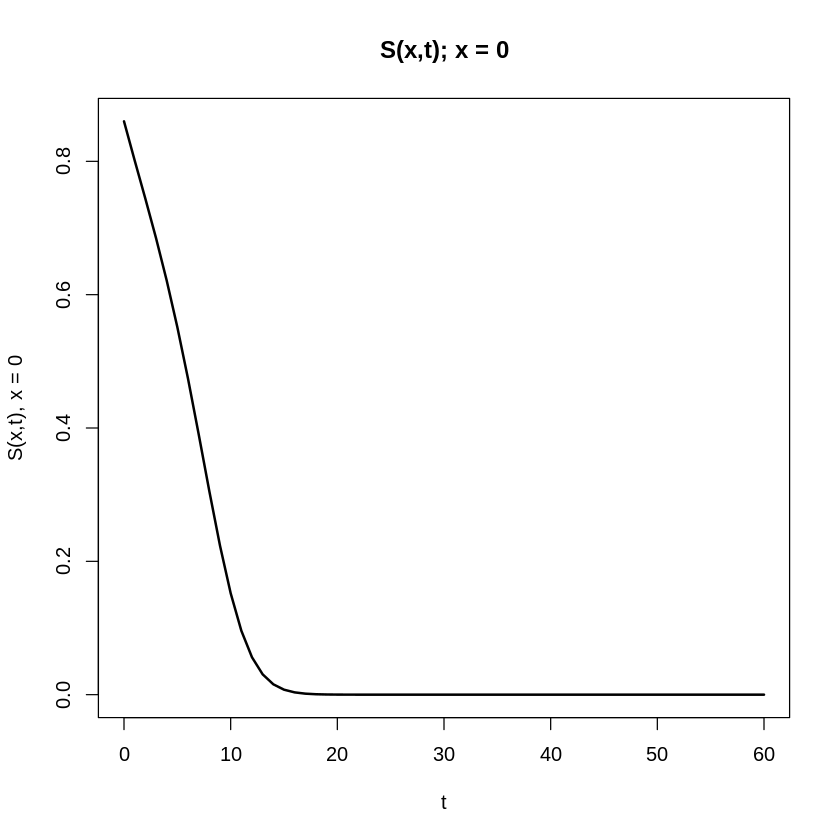

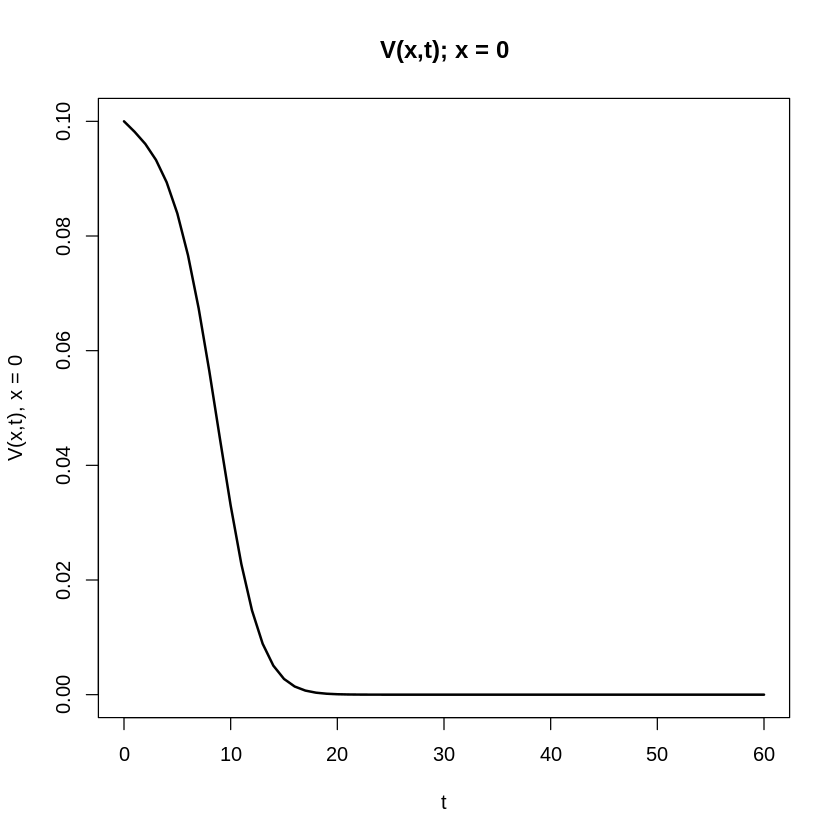

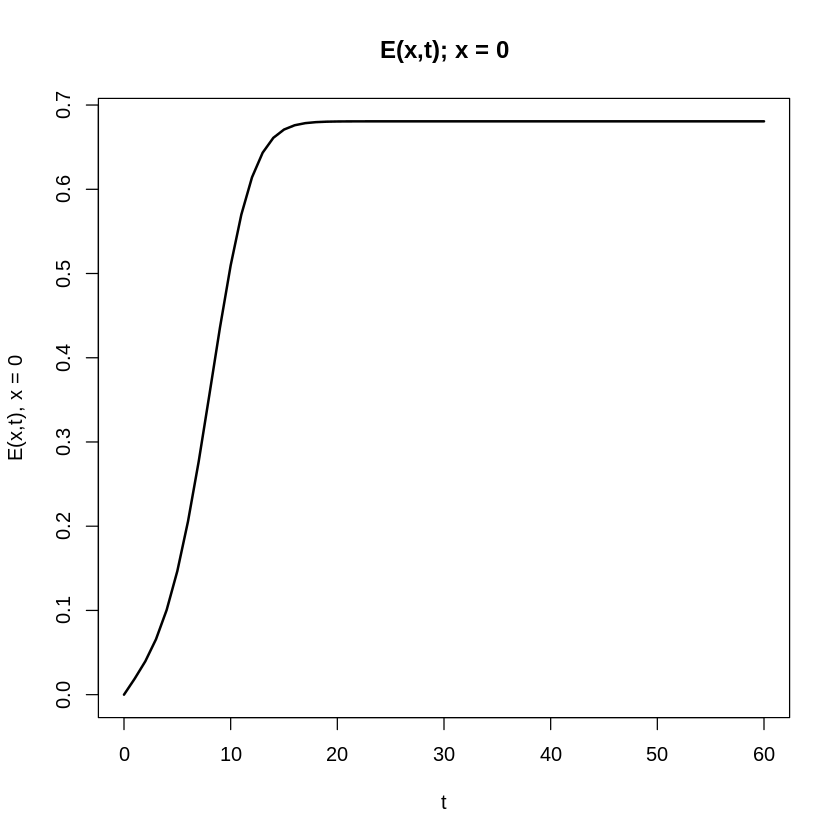

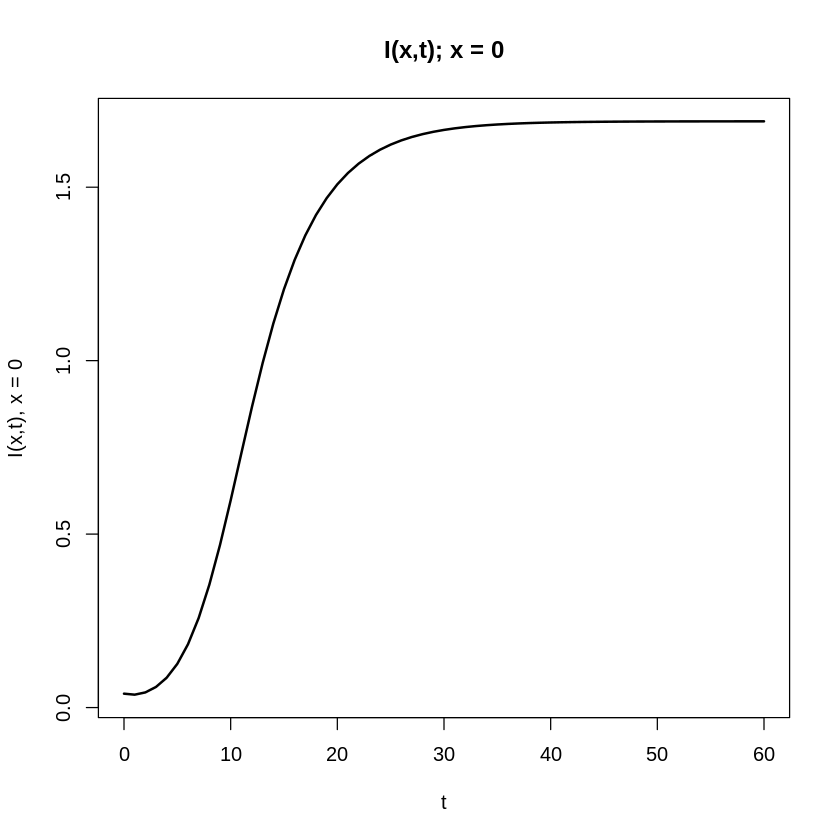

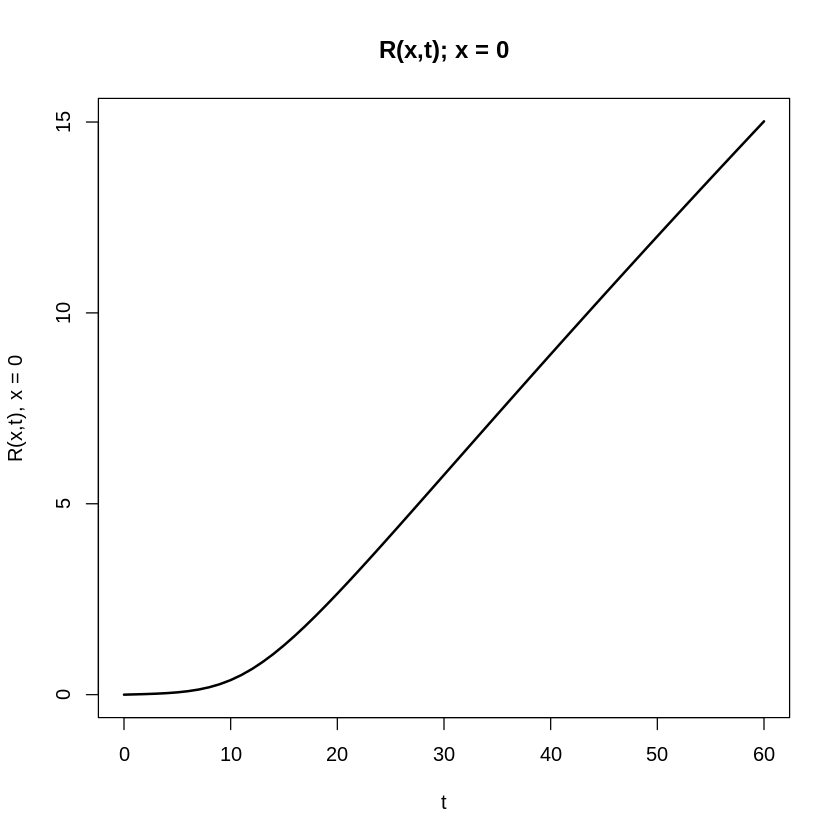

In [ ]:
# Access ODE integrator
library("deSolve");
#
# Access functions for analytical solutions
# setwd("c:/R/bme_pde/chap6");
#

# Format of output
#
# ip = 1 - graphical (plotted) solutions vs x with
# t as a parameter
#
# ip = 2 - graphical solutions vs t at specific x
#
ip=2;
#
# Grid in x
nx=61;xl=-3;xu=3;
xg=seq(from=xl,to=xu,by=(xu-xl)/(nx-1));
#
# Grid in t
if(ip==1){nout=11;t0=0;tf=60;}
if(ip==2){nout=61;t0=0;tf=60;}
# if(ip==2){nout=61;t0=0;tf=2000;}
tout=seq(from=t0,to=tf,by=(tf-t0)/(nout-1));
#
# Parameters
beta=0.5140; betae=0.250; betai=1; betav=0.9;
sigma=1/2; gamma=1/5; delta=1/365;
mu=5.50e-08;
r=1.140e-05; kappa=1.857e-04; alpha=9.30e-06;
theta=1/365;
phi=1/20; d1=0.05; d2=0.05; d3=0.025;
d4=0.001; d5=0;
#
# Display selected parameters
cat(sprintf(
"\n\n betav = %6.3f phi = %6.3f\n",betav,phi));
#
# ICs
u0=rep(0,5*nx);
for(ix in 1:nx){
u0[ix] =0.86*exp(-(xg[ix]/1.4)^2);
u0[ix+nx] =0.10*exp(-(xg[ix]/1.4)^2);
u0[ix+2*nx]=0;
u0[ix+3*nx]=0.04*exp(-xg[ix]^2);
u0[ix+4*nx]=0;
}
ncall=0;
#
# ODE integration
out=ode(y=u0,times=tout,func=flu_1,parms=NULL);
nrow(out)
ncol(out)
#
# Arrays for plotting numerical solutions
S_xplot=matrix(0,nrow=nx,ncol=nout);
V_xplot=matrix(0,nrow=nx,ncol=nout);
E_xplot=matrix(0,nrow=nx,ncol=nout);
I_xplot=matrix(0,nrow=nx,ncol=nout);
R_xplot=matrix(0,nrow=nx,ncol=nout);
for(it in 1:nout){
for(ix in 1:nx){
S_xplot[ix,it]=out[it,ix+1];
V_xplot[ix,it]=out[it,ix+1+nx];
E_xplot[ix,it]=out[it,ix+1+2*nx];
I_xplot[ix,it]=out[it,ix+1+3*nx];
R_xplot[ix,it]=out[it,ix+1+4*nx];
}
}
#
# Display numerical solutions (for t = 0, 60)
if(ip==1){
for(it in 1:nout){
if((it-1)*(it-11)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
if(ip==2){
for(it in 1:nout){
if((it-1)*(it-61)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
#
# Calls to ODE routine
cat(sprintf("\n\n ncall = %5d\n\n",ncall));
#
# Plot S,V,E,I,R numerical solutions
#
# vs x with t as a parameter, t = 0,6,...,60
if(ip==1){
par(mfrow=c(1,1));
matplot(x=xg,y=S_xplot,type="l",xlab="x",
ylab="S(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="S(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=V_xplot,type="l",xlab="x",
ylab="V(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="V(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=E_xplot,type="l",xlab="x",
ylab="E(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="E(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=I_xplot,type="l",xlab="x",
ylab="I(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="I(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=R_xplot,type="l",xlab="x",
ylab="R(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="R(x,t); t=0,6,...,60;",lwd=2);
}
#
# vs t at x = 0, t = 0,1,...,60
if(ip==2){
S_tplot=rep(0,nout);V_tplot=rep(0,nout);
E_tplot=rep(0,nout);I_tplot=rep(0,nout);
R_tplot=rep(0,nout);
for(it in 1:nout){
S_tplot[it]=S_xplot[31,it];
V_tplot[it]=V_xplot[31,it];
E_tplot[it]=E_xplot[31,it];
I_tplot[it]=I_xplot[31,it];
R_tplot[it]=R_xplot[31,it];
}
par(mfrow=c(1,1));
matplot(x=tout,y=S_tplot,type="l",xlab="t",
ylab="S(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="S(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=V_tplot,type="l",xlab="t",
ylab="V(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="V(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=E_tplot,type="l",xlab="t",
ylab="E(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="E(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=I_tplot,type="l",xlab="t",
ylab="I(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="I(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=R_tplot,type="l",xlab="t",
ylab="R(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="R(x,t); x = 0",lwd=2);
}

In [ ]:
# Transpose `out` so it becomes (306, 11)
df_out <- as.data.frame(t(out))

# Remove the first row (which contains time values)
df_out <- df_out[-1, ]  # Now it should be (305, 11)

# Rename columns using the actual time values (excluding the first one)
colnames(df_out) <- paste0("Out_SVEIR_t", tout)

# Convert `u0` into a data frame
df_u0 <- as.data.frame(u0)  # Ensure it's a column dataframe
colnames(df_u0) <- "SVEIR_Synth_Data"

# Debugging: Check dimensions before merging
print(dim(df_out))  # Should be (305, 11)
print(dim(df_u0))   # Should be (305, 1)

# Merge `u0` with `df_out`, ensuring the row counts match
df_final <- cbind(df_u0, df_out)

# Save the final DataFrame to a CSV file
write.csv(df_final, file = paste0("SVEIR_data_ip", ip, ".csv"), row.names = FALSE)

# Display first few rows for verification
head(df_final)

[1] 305  61
[1] 305   1


,SVEIR_Synth_Data,Out_SVEIR_t0,Out_SVEIR_t1,Out_SVEIR_t2,Out_SVEIR_t3,Out_SVEIR_t4,Out_SVEIR_t5,Out_SVEIR_t6,Out_SVEIR_t7,Out_SVEIR_t8,⋯,Out_SVEIR_t51,Out_SVEIR_t52,Out_SVEIR_t53,Out_SVEIR_t54,Out_SVEIR_t55,Out_SVEIR_t56,Out_SVEIR_t57,Out_SVEIR_t58,Out_SVEIR_t59,Out_SVEIR_t60
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.008715436,0.008715436,0.008290263,0.007885833,0.007501133,0.007135203,0.006787125,0.006456030,0.006141087,0.005841508,⋯,0.0006800861,0.0006469149,0.0006153563,0.0005853370,0.0005567839,0.0005296230,0.0005037870,0.0004792112,0.0004558343,0.0004335977
2,0.011776618,0.011776618,0.011202091,0.010655598,0.010135772,0.009641308,0.009170970,0.008723579,0.008298015,0.007893213,⋯,0.0009189401,0.0008741186,0.0008314758,0.0007909131,0.0007523317,0.0007156312,0.0006807212,0.0006475139,0.0006159265,0.0005858801
3,0.015751449,0.015751449,0.014982960,0.014251979,0.013556674,0.012895301,0.012266200,0.011667796,0.011098590,0.010557155,⋯,0.0012290280,0.0011690803,0.0011120467,0.0010577952,0.0010061937,0.0009571080,0.0009104169,0.0008660034,0.0008237563,0.0007835703
4,0.020853976,0.020853976,0.019836433,0.018868577,0.017947973,0.017072307,0.016239380,0.015447104,0.014693491,0.013976651,⋯,0.0016269417,0.0015475797,0.0014720757,0.0014002550,0.0013319426,0.0012669609,0.0012051495,0.0011463533,0.0010904254,0.0010372260
5,0.027329120,0.027329120,0.025995396,0.024726843,0.023520256,0.022372593,0.021280966,0.020242629,0.019254974,0.018315523,⋯,0.0021314720,0.0020274802,0.0019285445,0.0018344356,0.0017449243,0.0016597779,0.0015787860,0.0015017455,0.0014284638,0.0013587578
6,0.035451192,0.035451192,0.033720601,0.032074664,0.030509198,0.029020234,0.027604008,0.026256948,0.024975662,0.023756926,⋯,0.0027630850,0.0026282146,0.0024999032,0.0023778534,0.0022617678,0.0021513447,0.0020463109,0.0019464030,0.0018513710,0.0017609776


In [ ]:
# Transpose `out` so it becomes (306, 11)
df_out <- as.data.frame(t(out))

# Remove the first row (which contains time values)
df_out <- df_out[-1, ]  # Now it should be (305, 11)

# Rename columns using the actual time values (excluding the first one)
colnames(df_out) <- paste0("Out_SVEIR_t", tout)

# Convert `u0` into a data frame
df_u0 <- as.data.frame(u0)
colnames(df_u0) <- "SVEIR_Synth_Data"

# Create a new x column filled with zeros
x_column <- rep(0, length(u0))  # All values set to 0
df_x <- as.data.frame(x_column)
colnames(df_x) <- "x"

# Merge `x`, `u0`, and `df_out` together
df_final <- cbind(df_x, df_u0, df_out)

# Save the final DataFrame to a CSV file
write.csv(df_final, file = paste0("Test_SVEIR_data_ip", ip, ".csv"), row.names = FALSE)

# Display first few rows for verification
head(df_final)


,x,SVEIR_Synth_Data,Out_SVEIR_t0,Out_SVEIR_t1,Out_SVEIR_t2,Out_SVEIR_t3,Out_SVEIR_t4,Out_SVEIR_t5,Out_SVEIR_t6,Out_SVEIR_t7,⋯,Out_SVEIR_t51,Out_SVEIR_t52,Out_SVEIR_t53,Out_SVEIR_t54,Out_SVEIR_t55,Out_SVEIR_t56,Out_SVEIR_t57,Out_SVEIR_t58,Out_SVEIR_t59,Out_SVEIR_t60
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.008715436,0.008715436,0.008671327,0.008627444,0.008583785,0.008540349,0.008497135,0.008454141,0.008411367,⋯,6.775519e-03,6.745378e-03,6.715339e-03,6.685354e-03,6.655377e-03,6.625363e-03,6.595269e-03,6.565054e-03,6.534681e-03,6.504116e-03
2,0,0.021778409,0.021778409,0.021667937,0.021558071,0.021448799,0.021340108,0.021231989,0.021124431,0.021017424,⋯,1.697500e-02,1.691684e-02,1.685968e-02,1.680331e-02,1.674750e-02,1.669206e-02,1.663678e-02,1.658147e-02,1.652595e-02,1.647007e-02
3,0,0.049155281,0.049155281,0.048903235,0.048652969,0.048404351,0.048157275,0.047911656,0.047667423,0.047424519,⋯,3.765304e-02,3.742753e-02,3.719867e-02,3.696607e-02,3.672937e-02,3.648819e-02,3.624217e-02,3.599094e-02,3.573417e-02,3.547151e-02
4,0,0.100212343,0.100212343,0.099677390,0.099148871,0.098625452,0.098106082,0.097589921,0.097076278,0.096564575,⋯,5.610916e-02,5.395865e-02,5.175621e-02,4.951084e-02,4.723238e-02,4.493137e-02,4.261888e-02,4.030636e-02,3.800541e-02,3.572762e-02
5,0,0.184535212,0.184535212,0.183429684,0.182347504,0.181277611,0.180211066,0.179140263,0.178058321,0.176958616,⋯,4.402505e-03,3.491521e-03,2.760079e-03,2.175740e-03,1.710937e-03,1.342592e-03,1.051633e-03,8.224393e-04,6.423279e-04,5.010820e-04
6,0,0.306933488,0.306933488,0.304595788,0.302315145,0.300019619,0.297646430,0.295135312,0.292423311,0.289440381,⋯,3.047041e-06,1.958246e-06,1.261161e-06,8.048136e-07,5.145897e-07,3.310058e-07,2.103578e-07,1.343957e-07,8.600467e-08,5.505170e-08


In [ ]:
library(deSolve)

parameters <- c(
  a = -8/3,
  b = -10,
  c =  28)

state <- c(
  X = 1,
  Y = 1,
  Z = 1)

# ---- define function in R
Lorenz <- function(t, state, parameters) {
  with(as.list(c(state, parameters)),{
    # rate of change
    dX <- a*X + Y*Z
    dY <- b * (Y-Z)
    dZ <- -X*Y + c*Y - Z

    # return the rate of change
    list(c(dX, dY, dZ))
  })   # end with(as.list ...
}

times_1 <- seq(0, 100, by = 1)
out_1 <- lsoda(y = state, times = times_1, func = Lorenz, parms = parameters)

times_2 <- seq(0, 100, by = 0.01)
out_2 <- lsoda(y = state, times = times_2, func = Lorenz, parms = parameters)



 betav =  0.900 phi =  0.050


[1] 11

[1] 306



 t x S(x,t)
V(x,t)
 E(x,t) I(x,t)
R(x,t)
    0.0  -3.00     0.00872     0.00101
       0.00000     0.00000     0.00000
    0.0  -2.90     0.01178     0.00137
       0.00000     0.00001     0.00000
    0.0  -2.80     0.01575     0.00183
       0.00000     0.00002     0.00000
    0.0  -2.70     0.02085     0.00242
       0.00000     0.00003     0.00000
    0.0  -2.60     0.02733     0.00318
       0.00000     0.00005     0.00000
    0.0  -2.50     0.03545     0.00412
       0.00000     0.00008     0.00000
    0.0  -2.40     0.04552     0.00529
       0.00000     0.00013     0.00000
    0.0  -2.30     0.05786     0.00673
       0.00000     0.00020     0.00000
    0.0  -2.20     0.07279     0.00846
       0.00000     0.00032     0.00000
    0.0  -2.10     0.09064     0.01054
       0.00000     0.00049     0.00000
    0.0  -2.00     0.11173     0.01299
       0.00000     0.00073     0.00000
    0.0  -1.90     0.13633     0.01585
       0.00000     0.00108     0.00000
    0.0  -1.80     0.

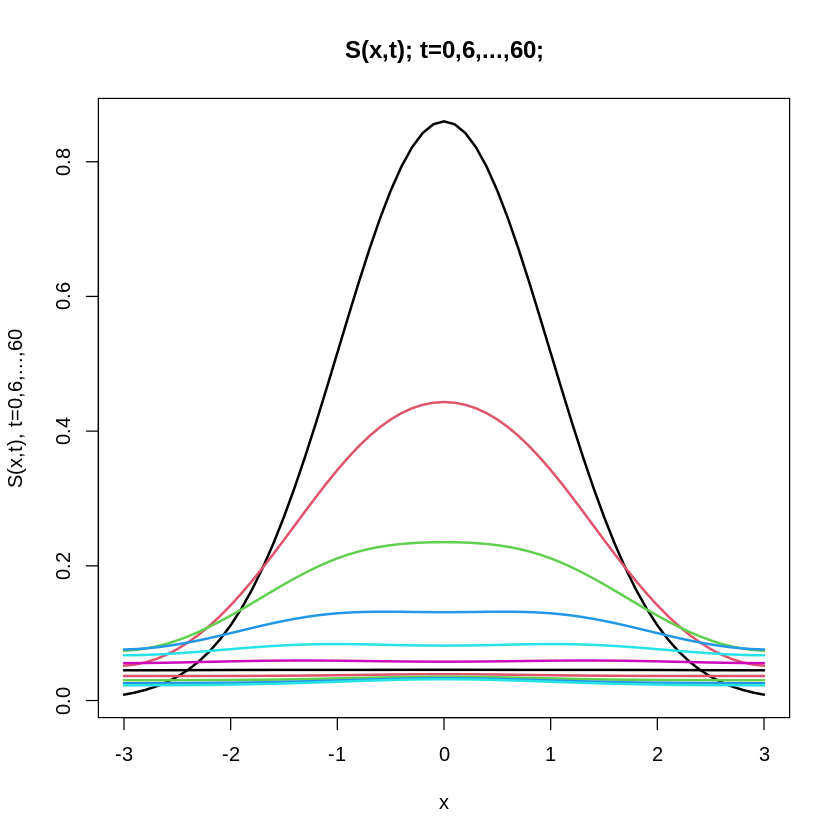

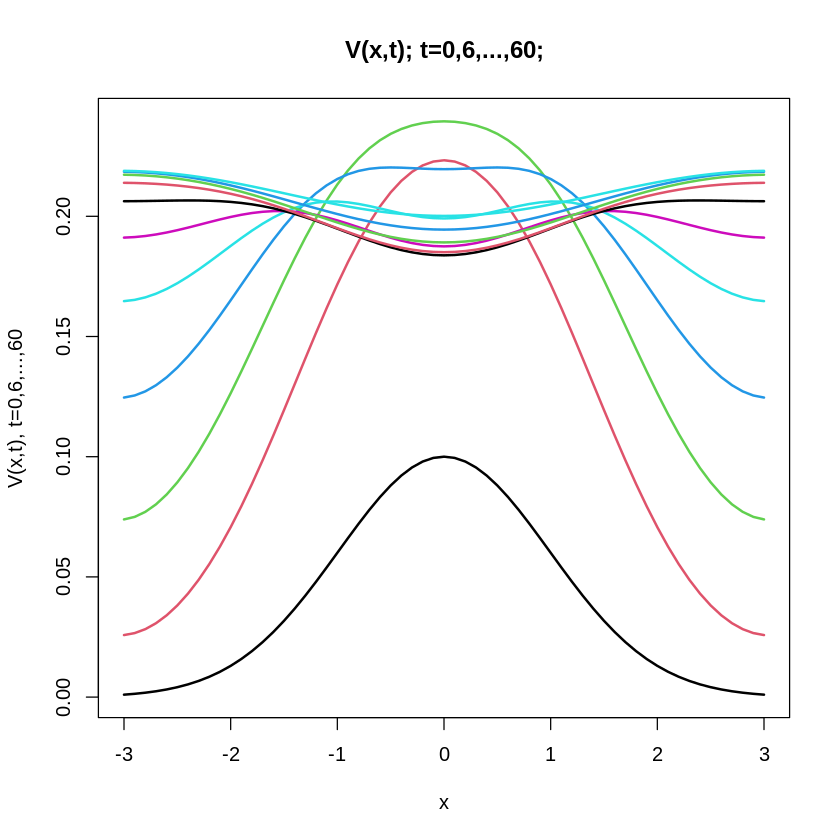

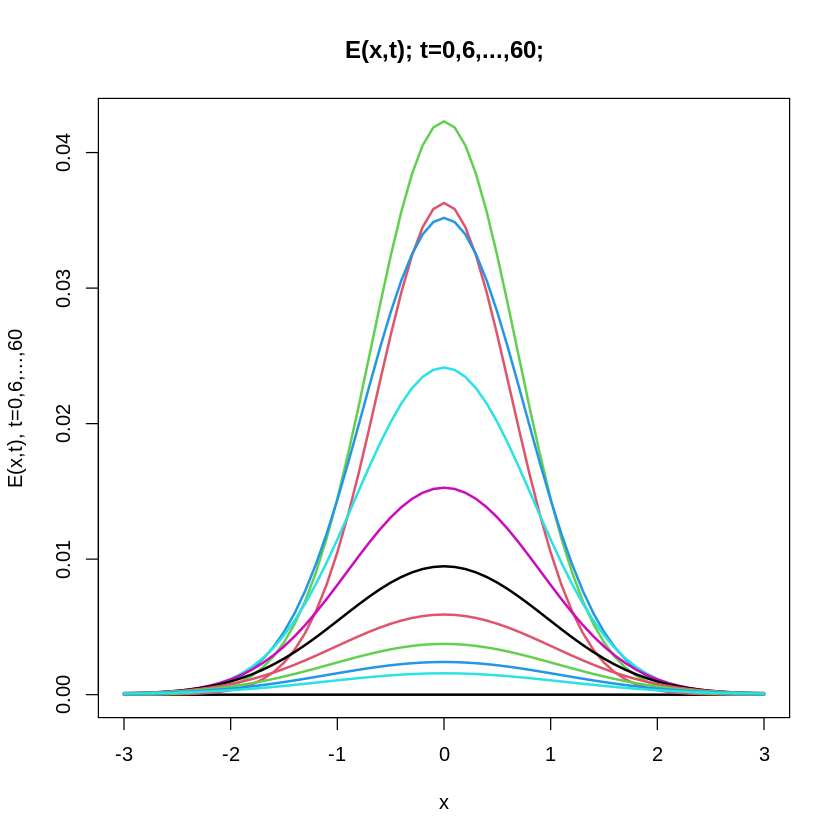

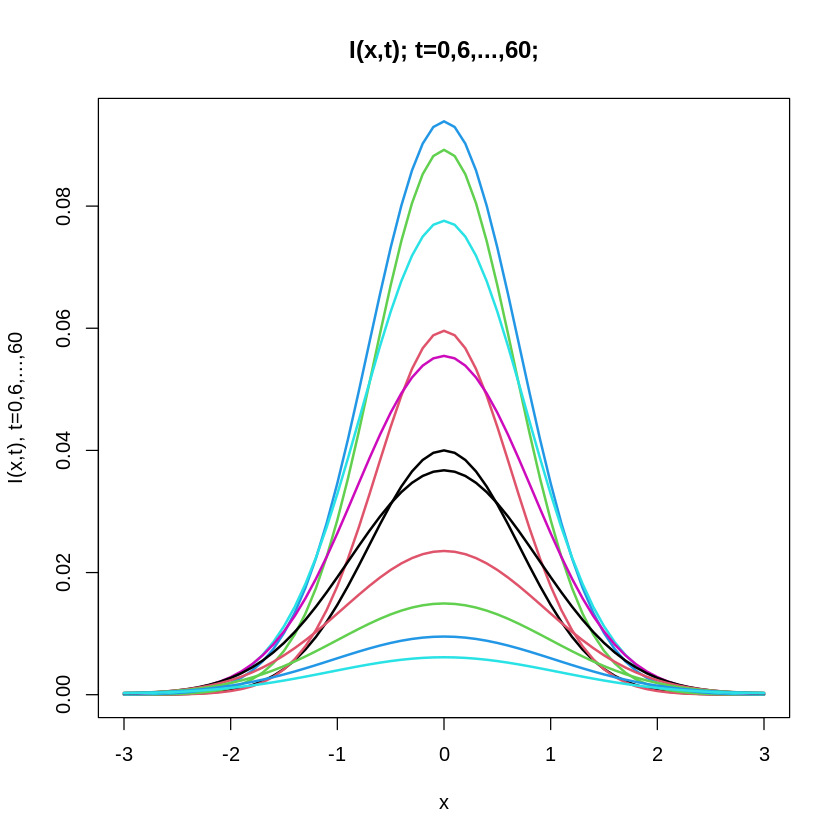

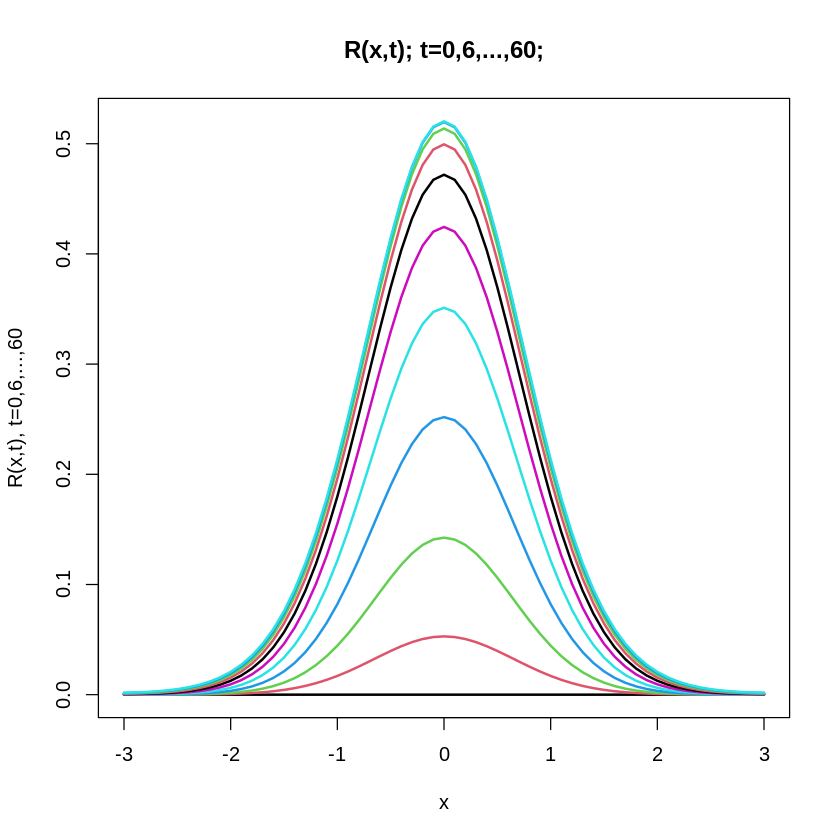

In [ ]:
# --- Modified flu_1 function for FVM ---
flu_1_fvm = function(t, u, parms) {
  # Function flu_1_fvm computes the t derivative vector using FVM

  # Unpack the u vector into S, V, E, I, R
  S = u[1:nx]
  V = u[(nx + 1):(2 * nx)]
  E = u[(2 * nx + 1):(3 * nx)]
  I = u[(3 * nx + 1):(4 * nx)]
  R = u[(4 * nx + 1):(5 * nx)]

  # Parameter definitions (same as before)
  b = beta
  be = betae
  bi = betai
  bv = betav
  a = alpha
  p = phi
  d = delta
  t = theta
  k = kappa
  s = sigma
  g = gamma

  # Initialize the derivative vector
  dudt = rep(0, 5 * nx)

  # Calculate cell widths (assuming uniform grid)
  dx = (xu - xl) / (nx - 1) # Corrected dx calculation

  # --- Flux Calculations (Central Differencing) ---
  # Assuming zero-flux BCs implemented directly

  # Function to calculate fluxes for each variable
  calculate_fluxes = function(var, d) {
    flux = rep(0, nx + 1) # n+1 boundaries
    for (i in 2:nx) {
      flux[i] = -d * (var[i] - var[i - 1]) / dx # Central difference
    }
    # Zero-flux BCs (flux at boundaries is 0)
    flux[1] <- 0  # Left Boundary
    flux[nx + 1] <- 0  # Right Boundary
    return(flux)
  }

  # Calculate fluxes for each variable
  flux_S = calculate_fluxes(S, d1)
  flux_V = calculate_fluxes(V, d2)
  flux_E = calculate_fluxes(E, d3)
  flux_I = calculate_fluxes(I, d4)
  flux_R = calculate_fluxes(R, d5)

  # --- Loop over cells and compute the change in each cell ---
  for (i in 1:nx) {

    # Source/Sink terms (ODE part)
    ES = E[i] * S[i]
    IS = I[i] * S[i]
    EV = E[i] * V[i]
    IV = I[i] * V[i]
    IE = I[i] * E[i]
    IR = I[i] * R[i]

    S_source = -b * be * ES - b * bi * IS + a * IS - p * S[i] - r * S[i] + d * R[i] + t * V[i] + r
    V_source = -b * be * bv * EV - b * bi * bv * IV + a * IV - r * V[i] - t * V[i] + p * S[i]
    E_source = b * be * ES + b * bi * IS + b * be * bv * EV + b * bi * bv * IV + a * IE - (r + k + s) * E[i]
    I_source = s * E[i] - (r + a + g) * I[i] + a * I[i]^2
    R_source = k * E[i] + g * I[i] - r * R[i] - d * R[i] + a * IR

    # Flux difference (FVM part) - Net Flux INTO the cell
    S_flux_diff = (flux_S[i] - flux_S[i+1]) / dx # Careful about signs
    V_flux_diff = (flux_V[i] - flux_V[i+1]) / dx
    E_flux_diff = (flux_E[i] - flux_E[i+1]) / dx
    I_flux_diff = (flux_I[i] - flux_I[i+1]) / dx
    R_flux_diff = (flux_R[i] - flux_R[i+1]) / dx

    # Update the derivatives
    dudt[i] = S_source + S_flux_diff # dS/dt
    dudt[i + nx] = V_source + V_flux_diff # dV/dt
    dudt[i + 2 * nx] = E_source + E_flux_diff # dE/dt
    dudt[i + 3 * nx] = I_source + I_flux_diff # dI/dt
    dudt[i + 4 * nx] = R_source + R_flux_diff # dR/dt

  }

  return(list(dudt)) # Must return as a list
}

# --- Main program (modifications needed) ---

# ip = 1 - graphical (plotted) solutions vs x with
# t as a parameter
#
# ip = 2 - graphical solutions vs t at specific x
#
ip=1;
#
# Grid in x
nx=61;xl=-3;xu=3;
xg=seq(from=xl,to=xu,by=(xu-xl)/(nx-1));
#
# Grid in t
if(ip==1){nout=11;t0=0;tf=60;}
if(ip==2){nout=61;t0=0;tf=60;}
# if(ip==2){nout=61;t0=0;tf=2000;}
tout=seq(from=t0,to=tf,by=(tf-t0)/(nout-1));
#
# Parameters
beta=0.5140; betae=0.250; betai=1; betav=0.9;
sigma=1/2; gamma=1/5; delta=1/365;
mu=5.50e-08;
r=1.140e-05; kappa=1.857e-04; alpha=9.30e-06;
theta=1/365;
phi=1/20; d1=0.05; d2=0.05; d3=0.025;
d4=0.001; d5=0;
#
# Display selected parameters
cat(sprintf(
"\n\n betav = %6.3f phi = %6.3f\n",betav,phi));

# Initial conditions (same as before)
u0 = rep(0, 5 * nx)
for (ix in 1:nx) {
  u0[ix] = 0.86 * exp(-(xg[ix] / 1.4)^2)
  u0[ix + nx] = 0.10 * exp(-(xg[ix] / 1.4)^2)
  u0[ix + 2 * nx] = 0
  u0[ix + 3 * nx] = 0.04 * exp(-xg[ix]^2)
  u0[ix + 4 * nx] = 0
}

ncall = 0

# ODE integration - IMPORTANT: Use the FVM version of flu_1
out = ode(y = u0, times = tout, func = flu_1_fvm, parms = NULL)
nrow(out)
ncol(out)
#
# Arrays for plotting numerical solutions
S_xplot=matrix(0,nrow=nx,ncol=nout);
V_xplot=matrix(0,nrow=nx,ncol=nout);
E_xplot=matrix(0,nrow=nx,ncol=nout);
I_xplot=matrix(0,nrow=nx,ncol=nout);
R_xplot=matrix(0,nrow=nx,ncol=nout);
for(it in 1:nout){
for(ix in 1:nx){
S_xplot[ix,it]=out[it,ix+1];
V_xplot[ix,it]=out[it,ix+1+nx];
E_xplot[ix,it]=out[it,ix+1+2*nx];
I_xplot[ix,it]=out[it,ix+1+3*nx];
R_xplot[ix,it]=out[it,ix+1+4*nx];
}
}
#
# Display numerical solutions (for t = 0, 60)
if(ip==1){
for(it in 1:nout){
if((it-1)*(it-11)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
if(ip==2){
for(it in 1:nout){
if((it-1)*(it-61)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
#
# Calls to ODE routine
cat(sprintf("\n\n ncall = %5d\n\n",ncall));
#
# Plot S,V,E,I,R numerical solutions
#
# vs x with t as a parameter, t = 0,6,...,60
if(ip==1){
par(mfrow=c(1,1));
matplot(x=xg,y=S_xplot,type="l",xlab="x",
ylab="S(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="S(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=V_xplot,type="l",xlab="x",
ylab="V(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="V(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=E_xplot,type="l",xlab="x",
ylab="E(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="E(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=I_xplot,type="l",xlab="x",
ylab="I(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="I(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=R_xplot,type="l",xlab="x",
ylab="R(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="R(x,t); t=0,6,...,60;",lwd=2);
}
#
# vs t at x = 0, t = 0,1,...,60
if(ip==2){
S_tplot=rep(0,nout);V_tplot=rep(0,nout);
E_tplot=rep(0,nout);I_tplot=rep(0,nout);
R_tplot=rep(0,nout);
for(it in 1:nout){
S_tplot[it]=S_xplot[31,it];
V_tplot[it]=V_xplot[31,it];
E_tplot[it]=E_xplot[31,it];
I_tplot[it]=I_xplot[31,it];
R_tplot[it]=R_xplot[31,it];
}
par(mfrow=c(1,1));
matplot(x=tout,y=S_tplot,type="l",xlab="t",
ylab="S(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="S(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=V_tplot,type="l",xlab="t",
ylab="V(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="V(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=E_tplot,type="l",xlab="t",
ylab="E(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="E(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=I_tplot,type="l",xlab="t",
ylab="I(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="I(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=R_tplot,type="l",xlab="t",
ylab="R(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="R(x,t); x = 0",lwd=2);
}



 betav =  0.900 phi =  0.050


[1] 11

[1] 306



 t x S(x,t)
V(x,t)
 E(x,t) I(x,t)
R(x,t)
    0.0  -3.00     0.00872     0.00101
       0.00000     0.00000     0.00000
    0.0  -2.90     0.01178     0.00137
       0.00000     0.00001     0.00000
    0.0  -2.80     0.01575     0.00183
       0.00000     0.00002     0.00000
    0.0  -2.70     0.02085     0.00242
       0.00000     0.00003     0.00000
    0.0  -2.60     0.02733     0.00318
       0.00000     0.00005     0.00000
    0.0  -2.50     0.03545     0.00412
       0.00000     0.00008     0.00000
    0.0  -2.40     0.04552     0.00529
       0.00000     0.00013     0.00000
    0.0  -2.30     0.05786     0.00673
       0.00000     0.00020     0.00000
    0.0  -2.20     0.07279     0.00846
       0.00000     0.00032     0.00000
    0.0  -2.10     0.09064     0.01054
       0.00000     0.00049     0.00000
    0.0  -2.00     0.11173     0.01299
       0.00000     0.00073     0.00000
    0.0  -1.90     0.13633     0.01585
       0.00000     0.00108     0.00000
    0.0  -1.80     0.

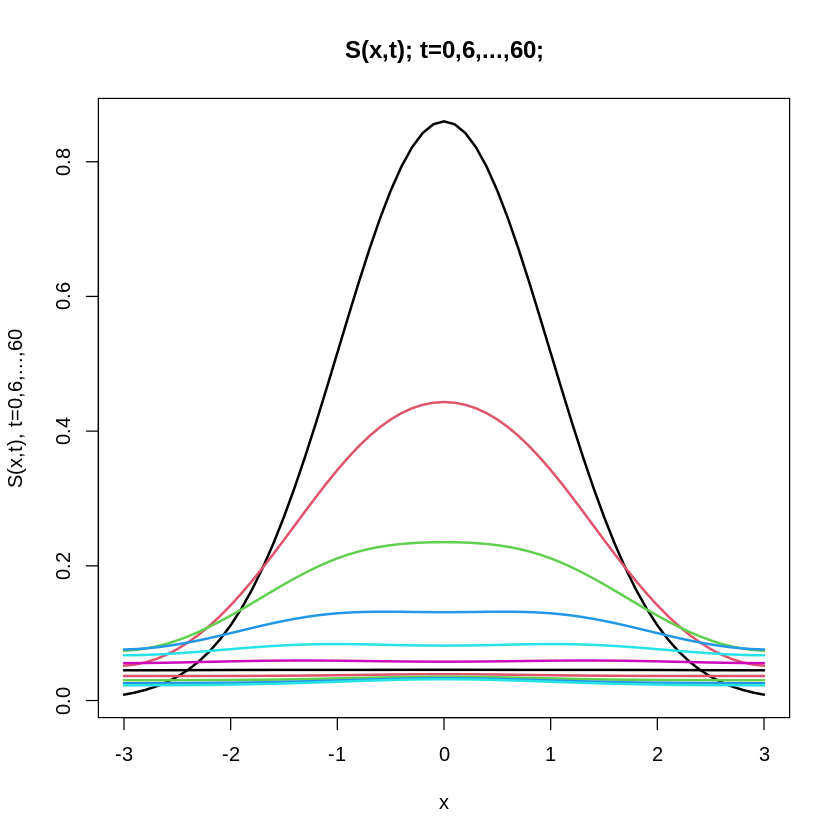

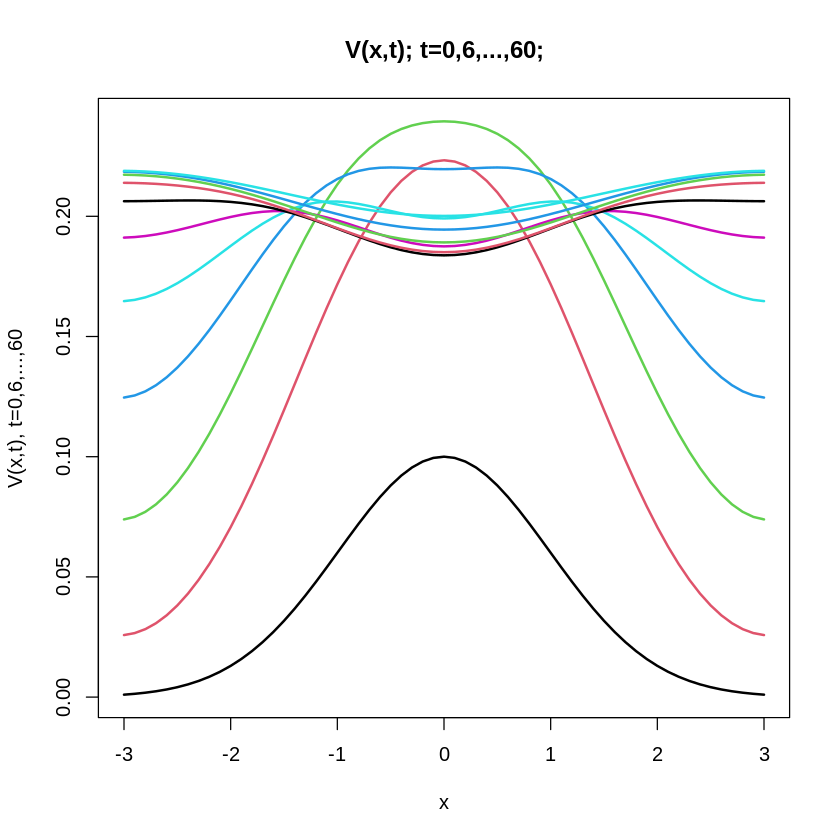

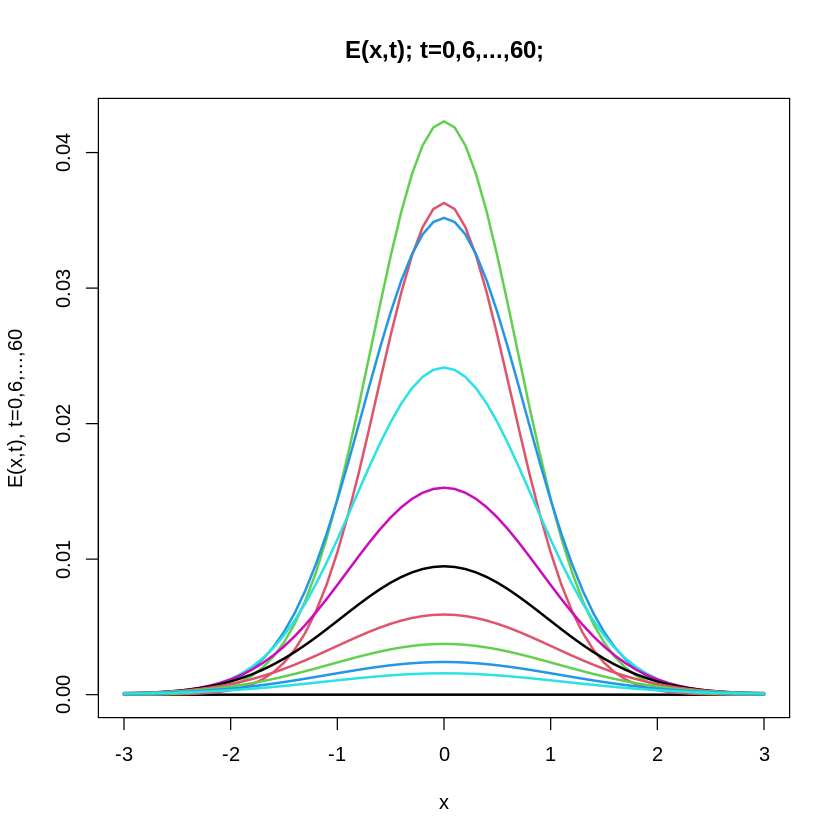

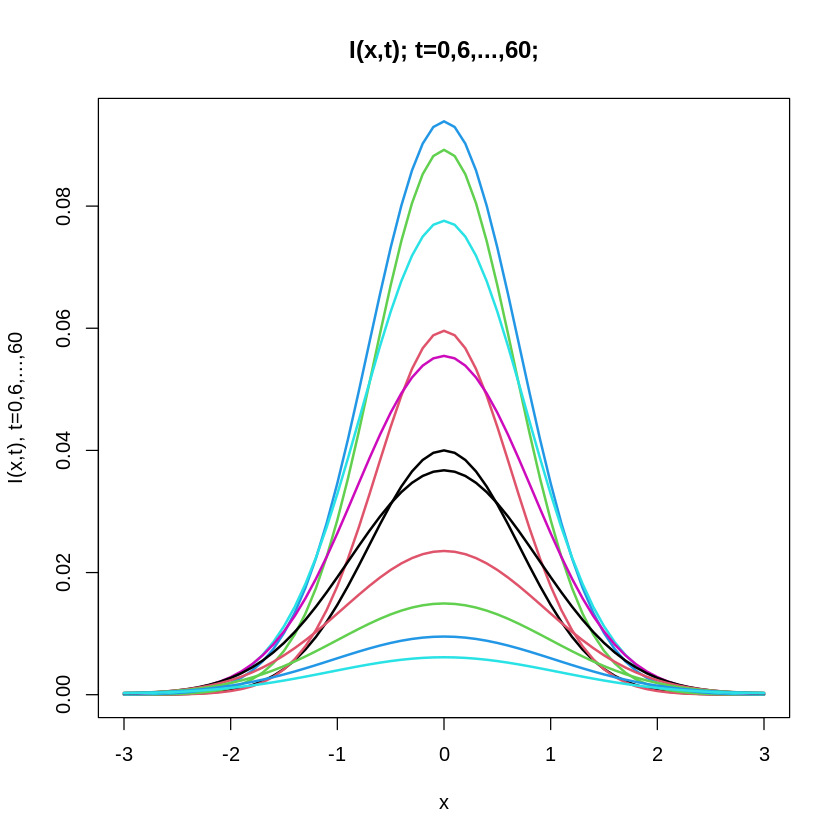

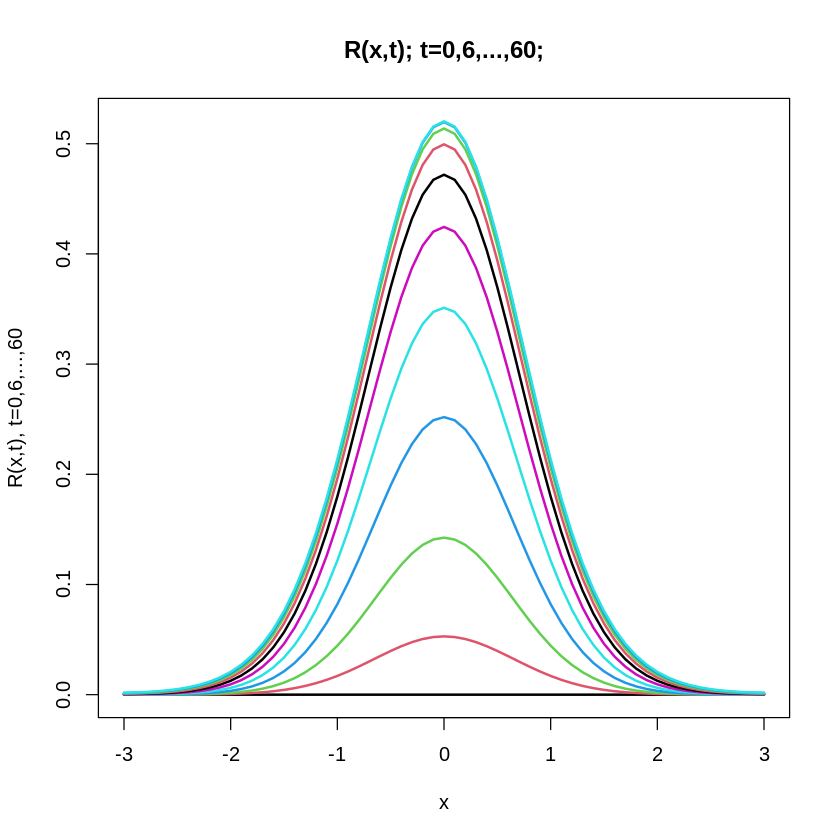

In [ ]:
# --- Corrected flu_1_fvm function for FVM with Diffusion ---
flu_1_fvm = function(t, u, parms) {
  # Function flu_1_fvm computes the t derivative vector using FVM with Diffusion

  # Unpack the u vector into S, V, E, I, R
  S = u[1:nx]
  V = u[(nx + 1):(2 * nx)]
  E = u[(2 * nx + 1):(3 * nx)]
  I = u[(3 * nx + 1):(4 * nx)]
  R = u[(4 * nx + 1):(5 * nx)]

  # Parameter definitions (same as before)
  b = beta
  be = betae
  bi = betai
  bv = betav
  a = alpha
  p = phi
  d = delta
  t = theta
  k = kappa
  s = sigma
  g = gamma

  # Initialize the derivative vector
  dudt = rep(0, 5 * nx)

  # Calculate cell widths (assuming uniform grid)
  dx = (xu - xl) / (nx - 1)

  # --- Flux Calculations (Central Differencing for Diffusion Terms) ---

  # Function to approximate d^2var/dx^2 using FVM-like stencil
  approximate_diffusion = function(var, d) {
    diffusion_term = rep(0, nx) # Result vector
    for (i in 2:(nx - 1)) {  # Loop from 2 to nx-1
      diffusion_term[i] = d * (var[i+1] - 2*var[i] + var[i-1]) / (dx^2)
    }

    # Boundary conditions: zero flux dS/dx = 0
    diffusion_term[1] <- d * (var[2] - var[1])/(dx^2)  #Left boundary.
    diffusion_term[nx] <- d * (var[nx-1] - var[nx])/(dx^2) #Right Boundary

    return(diffusion_term)
  }

  # Calculate Diffusion terms for each variable
  diffusion_S = approximate_diffusion(S, d1)
  diffusion_V = approximate_diffusion(V, d2)
  diffusion_E = approximate_diffusion(E, d3)
  diffusion_I = approximate_diffusion(I, d4)
  diffusion_R = approximate_diffusion(R, d5)

  # --- Loop over cells and compute the change in each cell ---
  for (i in 1:nx) {

    # Source/Sink terms (ODE part)
    ES = E[i] * S[i]
    IS = I[i] * S[i]
    EV = E[i] * V[i]
    IV = I[i] * V[i]
    IE = I[i] * E[i]
    IR = I[i] * R[i]

    S_source = -b * be * ES - b * bi * IS + a * IS - p * S[i] - r * S[i] + d * R[i] + t * V[i] + r
    V_source = -b * be * bv * EV - b * bi * bv * IV + a * IV - r * V[i] - t * V[i] + p * S[i]
    E_source = b * be * ES + b * bi * IS + b * be * bv * EV + b * bi * bv * IV + a * IE - (r + k + s) * E[i]
    I_source = s * E[i] - (r + a + g) * I[i] + a * I[i]^2
    R_source = k * E[i] + g * I[i] - r * R[i] - d * R[i] + a * IR


    # Update the derivatives - NOW INCLUDE DIFFUSION TERMS
    dudt[i] = S_source + diffusion_S[i] # dS/dt
    dudt[i + nx] = V_source + diffusion_V[i] # dV/dt
    dudt[i + 2 * nx] = E_source + diffusion_E[i] # dE/dt
    dudt[i + 3 * nx] = I_source + diffusion_I[i] # dI/dt
    dudt[i + 4 * nx] = R_source + diffusion_R[i] # dR/dt

  }

  return(list(dudt)) # Must return as a list
}

# --- Main program (modifications needed) ---

# ip = 1 - graphical (plotted) solutions vs x with
# t as a parameter
#
# ip = 2 - graphical solutions vs t at specific x
#
ip=1;
#
# Grid in x
nx=61;xl=-3;xu=3;
xg=seq(from=xl,to=xu,by=(xu-xl)/(nx-1));
#
# Grid in t
if(ip==1){nout=11;t0=0;tf=60;}
if(ip==2){nout=61;t0=0;tf=60;}
# if(ip==2){nout=61;t0=0;tf=2000;}
tout=seq(from=t0,to=tf,by=(tf-t0)/(nout-1));
#
# Parameters
beta=0.5140; betae=0.250; betai=1; betav=0.9;
sigma=1/2; gamma=1/5; delta=1/365;
mu=5.50e-08;
r=1.140e-05; kappa=1.857e-04; alpha=9.30e-06;
theta=1/365;
phi=1/20; d1=0.05; d2=0.05; d3=0.025;
d4=0.001; d5=0;
#
# Display selected parameters
cat(sprintf(
"\n\n betav = %6.3f phi = %6.3f\n",betav,phi));

# Initial conditions (same as before)
u0 = rep(0, 5 * nx)
for (ix in 1:nx) {
  u0[ix] = 0.86 * exp(-(xg[ix] / 1.4)^2)
  u0[ix + nx] = 0.10 * exp(-(xg[ix] / 1.4)^2)
  u0[ix + 2 * nx] = 0
  u0[ix + 3 * nx] = 0.04 * exp(-xg[ix]^2)
  u0[ix + 4 * nx] = 0
}

ncall = 0

# ODE integration - IMPORTANT: Use the FVM version of flu_1
out = ode(y = u0, times = tout, func = flu_1_fvm, parms = NULL)
nrow(out)
ncol(out)
#
# Arrays for plotting numerical solutions
S_xplot=matrix(0,nrow=nx,ncol=nout);
V_xplot=matrix(0,nrow=nx,ncol=nout);
E_xplot=matrix(0,nrow=nx,ncol=nout);
I_xplot=matrix(0,nrow=nx,ncol=nout);
R_xplot=matrix(0,nrow=nx,ncol=nout);
for(it in 1:nout){
for(ix in 1:nx){
S_xplot[ix,it]=out[it,ix+1];
V_xplot[ix,it]=out[it,ix+1+nx];
E_xplot[ix,it]=out[it,ix+1+2*nx];
I_xplot[ix,it]=out[it,ix+1+3*nx];
R_xplot[ix,it]=out[it,ix+1+4*nx];
}
}
#
# Display numerical solutions (for t = 0, 60)
if(ip==1){
for(it in 1:nout){
if((it-1)*(it-11)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
if(ip==2){
for(it in 1:nout){
if((it-1)*(it-61)==0){
cat(sprintf("\n\n t x S(x,t)
V(x,t)"));
cat(sprintf("\n E(x,t) I(x,t)
R(x,t)"));
for(ix in 1:nx){
cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
cat(sprintf("\n%14.5f%12.5f%12.5f",
E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
}
}
}
}
#
# Calls to ODE routine
cat(sprintf("\n\n ncall = %5d\n\n",ncall));
#
# Plot S,V,E,I,R numerical solutions
#
# vs x with t as a parameter, t = 0,6,...,60
if(ip==1){
par(mfrow=c(1,1));
matplot(x=xg,y=S_xplot,type="l",xlab="x",
ylab="S(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="S(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=V_xplot,type="l",xlab="x",
ylab="V(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="V(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=E_xplot,type="l",xlab="x",
ylab="E(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="E(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=I_xplot,type="l",xlab="x",
ylab="I(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="I(x,t); t=0,6,...,60;",lwd=2);
par(mfrow=c(1,1));
matplot(x=xg,y=R_xplot,type="l",xlab="x",
ylab="R(x,t), t=0,6,...,60",xlim=c(xl,xu),
lty=1,main="R(x,t); t=0,6,...,60;",lwd=2);
}
#
# vs t at x = 0, t = 0,1,...,60
if(ip==2){
S_tplot=rep(0,nout);V_tplot=rep(0,nout);
E_tplot=rep(0,nout);I_tplot=rep(0,nout);
R_tplot=rep(0,nout);
for(it in 1:nout){
S_tplot[it]=S_xplot[31,it];
V_tplot[it]=V_xplot[31,it];
E_tplot[it]=E_xplot[31,it];
I_tplot[it]=I_xplot[31,it];
R_tplot[it]=R_xplot[31,it];
}
par(mfrow=c(1,1));
matplot(x=tout,y=S_tplot,type="l",xlab="t",
ylab="S(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="S(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=V_tplot,type="l",xlab="t",
ylab="V(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="V(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=E_tplot,type="l",xlab="t",
ylab="E(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="E(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=I_tplot,type="l",xlab="t",
ylab="I(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="I(x,t); x = 0",lwd=2);
par(mfrow=c(1,1));
matplot(x=tout,y=R_tplot,type="l",xlab="t",
ylab="R(x,t), x = 0",xlim=c(t0,tf),lty=1,
main="R(x,t); x = 0",lwd=2);
}



 betav =  0.900 phi =  0.050


[1] 11

[1] 306



 t      x      S(x,t)     V(x,t)     E(x,t)     I(x,t)     R(x,t)
    0.0  -3.00     0.00872     0.00101       0.00000     0.00000     0.00000
    0.0  -2.90     0.01178     0.00137       0.00000     0.00001     0.00000
    0.0  -2.80     0.01575     0.00183       0.00000     0.00002     0.00000
    0.0  -2.70     0.02085     0.00242       0.00000     0.00003     0.00000
    0.0  -2.60     0.02733     0.00318       0.00000     0.00005     0.00000
    0.0  -2.50     0.03545     0.00412       0.00000     0.00008     0.00000
    0.0  -2.40     0.04552     0.00529       0.00000     0.00013     0.00000
    0.0  -2.30     0.05786     0.00673       0.00000     0.00020     0.00000
    0.0  -2.20     0.07279     0.00846       0.00000     0.00032     0.00000
    0.0  -2.10     0.09064     0.01054       0.00000     0.00049     0.00000
    0.0  -2.00     0.11173     0.01299       0.00000     0.00073     0.00000
    0.0  -1.90     0.13633     0.01585       0.00000     0.00108     0.00000
    0.0 

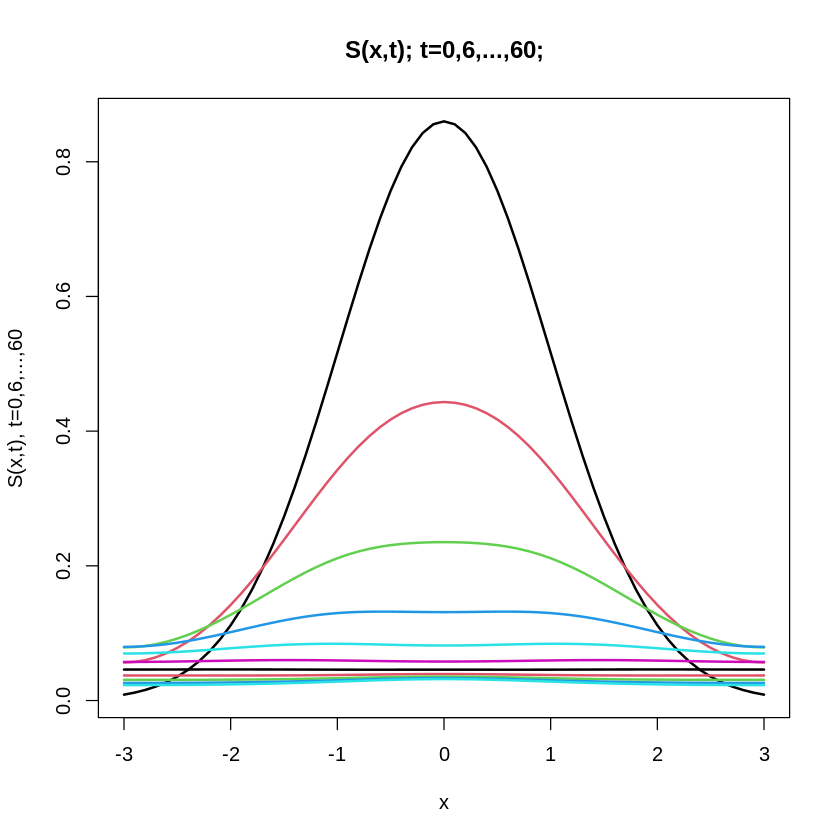

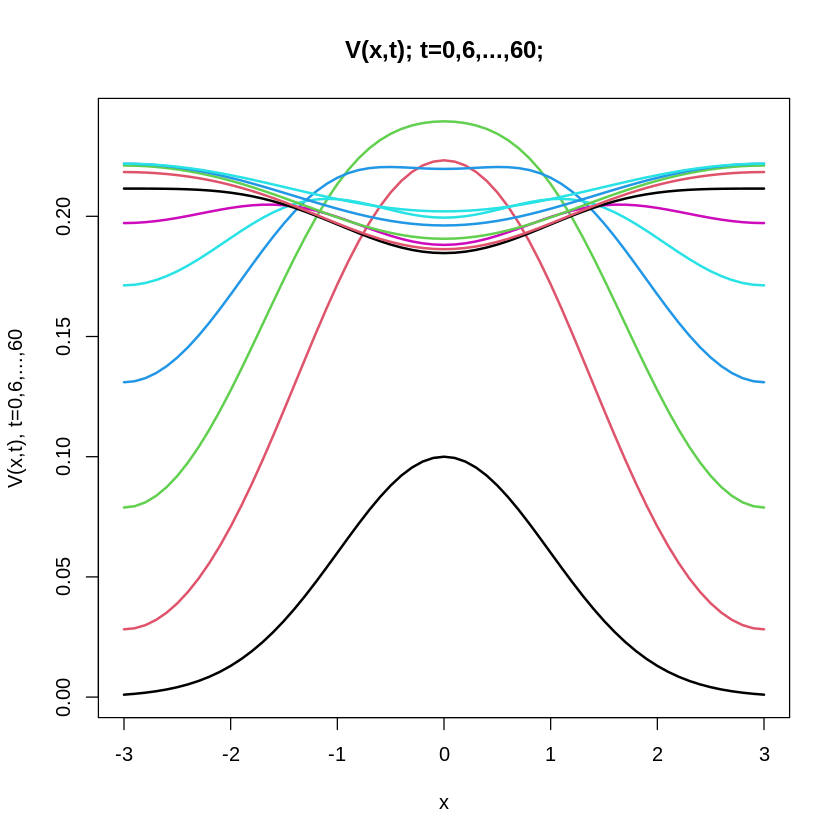

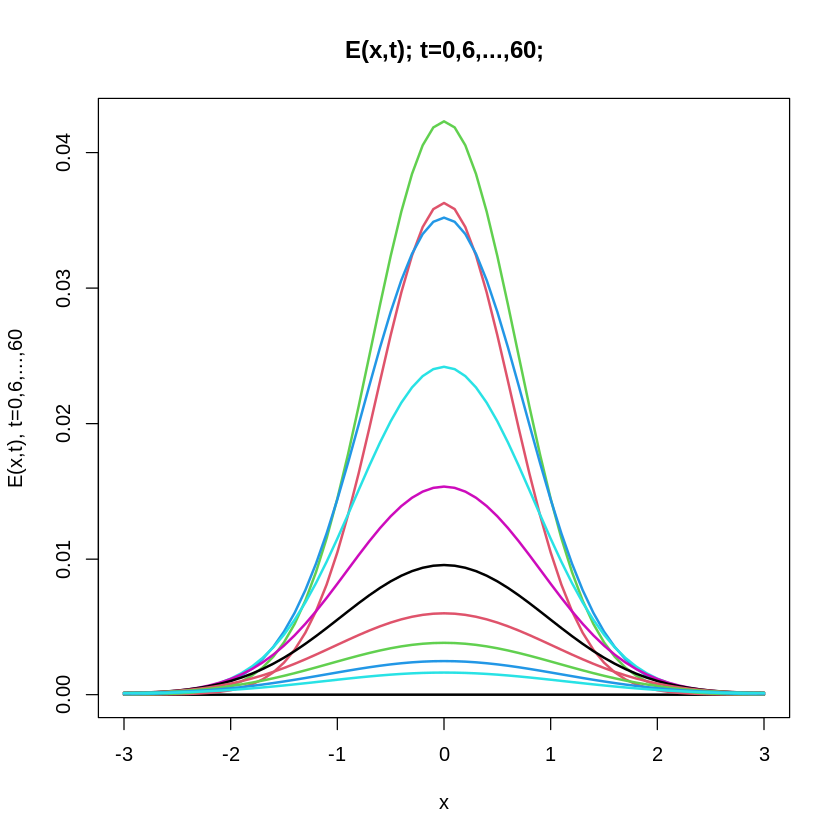

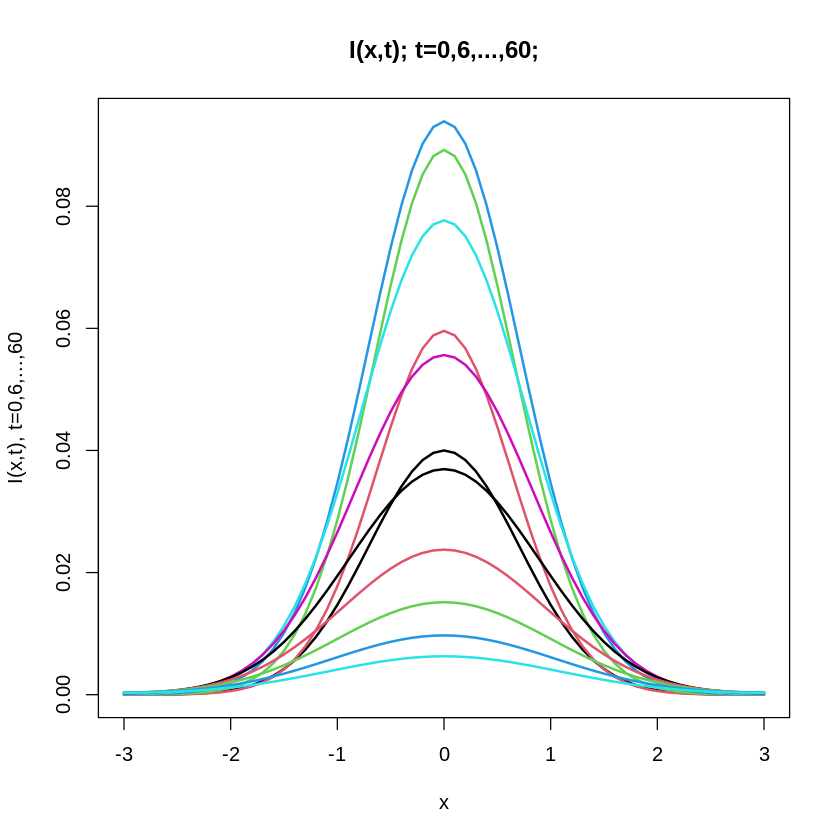

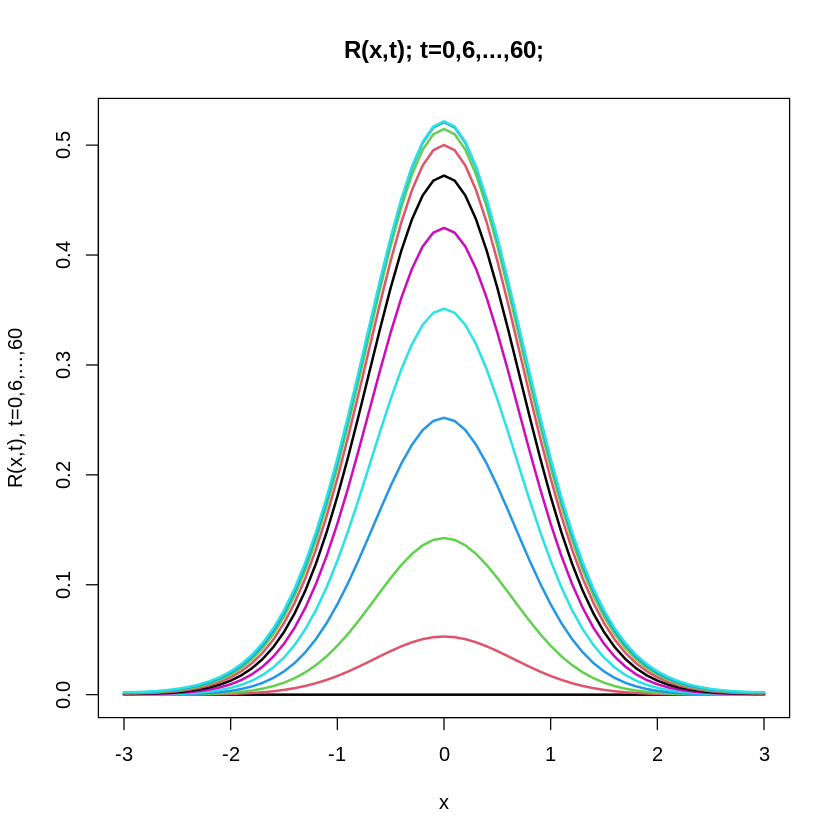

In [ ]:
# --- Modified flu_1 function for FVM ---
flu_1=function(t,u,parms){
  # Function flu_1 computes the t derivative vector using FVM

  # Unpack the u vector into S, V, E, I, R
  S=u[1:nx];V=u[(nx+1):(2*nx)];
  E=u[(2*nx+1):(3*nx)];I=u[(3*nx+1):(4*nx)];
  R=u[(4*nx+1):(5*nx)];

  # Parameter definitions (same as before)
  b=beta;be=betae;bi=betai;bv=betav;
  a=alpha;p=phi;d=delta;t=theta;k=kappa;
  s=sigma;g=gamma;

  # Initialize the derivative vector
  dudt=rep(0,5*nx);

  # Calculate cell widths (assuming uniform grid)
  dx = (xu - xl) / (nx - 1)

  # --- Function for BCs using ghost points ---
  S = c(S[2], S, S[nx-1])  # Ghost points for S
  V = c(V[2], V, V[nx-1])  # Ghost points for V
  E = c(E[2], E, E[nx-1])  # Ghost points for E
  I = c(I[2], I, I[nx-1])  # Ghost points for I
  R = c(R[2], R, R[nx-1])  # Ghost points for R

  # --- FVM Diffusion Approximation ---
  approx_diffusion = function(var, d) {
    diffusion_term = rep(0, nx)
    for (i in 1:nx) {
      diffusion_term[i] = d * (var[i+2] - 2*var[i+1] + var[i]) / (dx^2) # Central diff with ghost cells
    }
    return(diffusion_term)
  }

  # Get Diffusion for all the functions
  diffusion_S = approx_diffusion(S, d1)
  diffusion_V = approx_diffusion(V, d2)
  diffusion_E = approx_diffusion(E, d3)
  diffusion_I = approx_diffusion(I, d4)
  diffusion_R = approx_diffusion(R, d5)

  # Source loop of the FVM
  for(i in 1:nx){
    ES=E[i+1]*S[i+1]; #Shift indices to account for ghost points.
    IS=I[i+1]*S[i+1];
    EV=E[i+1]*V[i+1];
    IV=I[i+1]*V[i+1];
    IE=I[i+1]*E[i+1];
    IR=I[i+1]*R[i+1];

    #Update everything with the formulas
    dudt[i]   = -b*be*ES - b*bi*IS + a*IS - p*S[i+1] - r*S[i+1] + d*R[i+1] + t*V[i+1] + r + diffusion_S[i]
    dudt[i+nx] = -b*be*bv*EV - b*bi*bv*IV + a*IV - r*V[i+1] - t*V[i+1] + p*S[i+1] + diffusion_V[i]
    dudt[i+2*nx]= b*be*ES  + b*bi*IS + b*be*bv*EV + b*bi*bv*IV + a*IE - (r+k+s)*E[i+1] + diffusion_E[i]
    dudt[i+3*nx]= s*E[i+1]  - (r+a+g)*I[i+1] + a*I[i+1]^2 + diffusion_I[i]
    dudt[i+4*nx]= k*E[i+1]  + g*I[i+1] - r*R[i+1] - d*R[i+1] + a*IR + diffusion_R[i]
  }

  # Increment calls to flu_1
  ncall <<- ncall+1;
  # Return derivative vector
  return(list(c(dudt)));
}

# --- Modified Main Program (minimal changes) ---
# IMPORTANT CHANGES:
# - 1. comment out the first and second derivatives
# - 2. correct the main function to only use the function flu_1
# - 3. add Ghost Boundaries, otherwise indexing will be off
#
# Access ODE integrator
library("deSolve");
#
# Access functions for analytical solutions
#setwd("c:/R/bme_pde/chap6");
# source("flu_1.R")  #NO SOURCE THIS
# source("dss004.R") #NO SOURCE THIS
# source("dss044.R") #NO SOURCE THIS
#
# Format of output
#
# ip = 1 - graphical (plotted) solutions vs x with
# t as a parameter
#
# ip = 2 - graphical solutions vs t at specific x
#
ip=1;
#
# Grid in x
nx=61;xl=-3;xu=3;
xg=seq(from=xl,to=xu,by=(xu-xl)/(nx-1));
#
# Grid in t
if(ip==1){nout=11;t0=0;tf=60;}
if(ip==2){nout=61;t0=0;tf=60;}
# if(ip==2){nout=61;t0=0;tf=2000;}
tout=seq(from=t0,to=tf,by=(tf-t0)/(nout-1));
#
# Parameters
beta=0.5140; betae=0.250; betai=1; betav=0.9;
sigma=1/2; gamma=1/5; delta=1/365;
mu=5.50e-08;
r=1.140e-05; kappa=1.857e-04; alpha=9.30e-06;
theta=1/365;
phi=1/20; d1=0.05; d2=0.05; d3=0.025;
d4=0.001; d5=0;
#
# Display selected parameters
cat(sprintf(
"\n\n betav = %6.3f phi = %6.3f\n",betav,phi));
#
# ICs
u0=rep(0,5*nx);
for(ix in 1:nx){
  u0[ix] =0.86*exp(-(xg[ix]/1.4)^2);
  u0[ix+nx] =0.10*exp(-(xg[ix]/1.4)^2);
  u0[ix+2*nx]=0;
  u0[ix+3*nx]=0.04*exp(-xg[ix]^2);
  u0[ix+4*nx]=0;
}
ncall=0;
#
# ODE integration
out=ode(y=u0,times=tout,func=flu_1,parms=NULL);
nrow(out)
ncol(out)
#
# Arrays for plotting numerical solutions
S_xplot=matrix(0,nrow=nx,ncol=nout);
V_xplot=matrix(0,nrow=nx,ncol=nout);
E_xplot=matrix(0,nrow=nx,ncol=nout);
I_xplot=matrix(0,nrow=nx,ncol=nout);
R_xplot=matrix(0,nrow=nx,ncol=nout);
for(it in 1:nout){
  for(ix in 1:nx){
    S_xplot[ix,it]=out[it,ix+1];
    V_xplot[ix,it]=out[it,ix+1+nx];
    E_xplot[ix,it]=out[it,ix+1+2*nx];
    I_xplot[ix,it]=out[it,ix+1+3*nx];
    R_xplot[ix,it]=out[it,ix+1+4*nx];
  }
}
#
# Display numerical solutions (for t = 0, 60)
if(ip==1){
  for(it in 1:nout){
    if((it-1)*(it-11)==0){
      cat(sprintf("\n\n t      x      S(x,t)     V(x,t)"));
      cat(sprintf("     E(x,t)     I(x,t)     R(x,t)"));
      for(ix in 1:nx){
        cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
                    tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
        cat(sprintf("  %12.5f%12.5f%12.5f",
                    E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
      }
    }
  }
}
if(ip==2){
  for(it in 1:nout){
    if((it-1)*(it-61)==0){
      cat(sprintf("\n\n t      x      S(x,t)     V(x,t)"));
      cat(sprintf("     E(x,t)     I(x,t)     R(x,t)"));
      for(ix in 1:nx){
        cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
                    tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
        cat(sprintf("  %12.5f%12.5f%12.5f",
                    E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
      }
    }
  }
}
#
# Calls to ODE routine
cat(sprintf("\n\n ncall = %5d\n\n",ncall));
#
# Plot S,V,E,I,R numerical solutions
#
# vs x with t as a parameter, t = 0,6,...,60
if(ip==1){
  par(mfrow=c(1,1));
  matplot(x=xg,y=S_xplot,type="l",xlab="x",
          ylab="S(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="S(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=V_xplot,type="l",xlab="x",
          ylab="V(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="V(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=E_xplot,type="l",xlab="x",
          ylab="E(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="E(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=I_xplot,type="l",xlab="x",
          ylab="I(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="I(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=R_xplot,type="l",xlab="x",
          ylab="R(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="R(x,t); t=0,6,...,60;",lwd=2);
}
#
# vs t at x = 0, t = 0,1,...,60
if(ip==2){
  S_tplot=rep(0,nout);V_tplot=rep(0,nout);
  E_tplot=rep(0,nout);I_tplot=rep(0,nout);
  R_tplot=rep(0,nout);
  for(it in 1:nout){
    S_tplot[it]=S_xplot[31,it];
    V_tplot[it]=V_xplot[31,it];
    E_tplot[it]=E_xplot[31,it];
    I_tplot[it]=I_xplot[31,it];
    R_tplot[it]=R_xplot[31,it];
  }
  par(mfrow=c(1,1));
  matplot(x=tout,y=S_tplot,type="l",xlab="t",
          ylab="S(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="S(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=V_tplot,type="l",xlab="t",
          ylab="V(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="V(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=E_tplot,type="l",xlab="t",
          ylab="E(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="E(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=I_tplot,type="l",xlab="t",
          ylab="I(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="I(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=R_tplot,type="l",xlab="t",
          ylab="R(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="R(x,t); x = 0",lwd=2);
}

In [ ]:
# --- Modified flu_1 function for Spectral Method (Chebyshev) ---
flu_1_spectral = function(t, u, parms) {
  # Function flu_1_spectral computes the t derivative vector using a Chebyshev spectral method.

  # Unpack the u vector into S, V, E, I, R (Chebyshev coefficients)
  S = u[1:nx]
  V = u[(nx + 1):(2 * nx)]
  E = u[(2 * nx + 1):(3 * nx)]
  I = u[(3 * nx + 1):(4 * nx)]
  R = u[(4 * nx + 1):(5 * nx)]

  # Parameter definitions
  b = beta
  be = betae
  bi = betai
  bv = betav
  a = alpha
  p = phi
  d = delta
  t = theta
  k = kappa
  s = sigma
  g = gamma

  # Initialize the derivative vector
  dudt = rep(0, 5 * nx)

  # --- Compute derivatives using Chebyshev polynomials ---
  # Function to compute first and second derivatives
  chebyshev_derivatives = function(coeffs, d) {
    # Args: Chebyshev coefficients, diffusion coefficient
    # Returns: vector of coefficients for S', S''

    N = length(coeffs) - 1 # Polynomial degree
    if(N < 2){return(list(rep(0,N+1),rep(0,N+1)))}
    # Compute differentiation matrices (2nd order and 4th)
    D <- cheb(N)

    # Compute first and second derivatives in physical space

    dvar_dx <- D %*% coeffs

    d2var_dx2 <- D %*% dvar_dx #Apply diff matrix twice for second order
    return(list(dvar_dx,d2var_dx2))
  }


  # Calculate derivatives for each variable
  S_derivs = chebyshev_derivatives(S, d1)
  V_derivs = chebyshev_derivatives(V, d2)
  E_derivs = chebyshev_derivatives(E, d3)
  I_derivs = chebyshev_derivatives(I, d4)
  R_derivs = chebyshev_derivatives(R, d5)

  dS_dx = S_derivs[[1]]
  dS_dx2 = S_derivs[[2]]

  dV_dx = V_derivs[[1]]
  dV_dx2 = V_derivs[[2]]

  dE_dx = E_derivs[[1]]
  dE_dx2 = E_derivs[[2]]

  dI_dx = I_derivs[[1]]
  dI_dx2 = I_derivs[[2]]

  dR_dx = R_derivs[[1]]
  dR_dx2 = R_derivs[[2]]


  # --- Compute time derivatives (Galerkin or Collocation) ---
  for (i in 1:nx) {

    # Spectral method: now uses Chebyshev coefficients

    S_val =  S[i] # Spectral coefficients already encode the function value
    V_val =  V[i] # Spectral coefficients already encode the function value
    E_val =  E[i] # Spectral coefficients already encode the function value
    I_val =  I[i] # Spectral coefficients already encode the function value
    R_val =  R[i] # Spectral coefficients already encode the function value


    ES = E_val * S_val
    IS = I_val * S_val
    EV = E_val * V_val
    IV = I_val * V_val
    IE = I_val * E_val
    IR = I_val * R_val


    # Update the derivatives - NOW INCLUDE DIFFUSION TERMS
    dudt[i] = -b*be*ES - b*bi*IS + a*IS - p*S_val - r*S_val + d*R_val + t*V_val + r  + d1 * dS_dx2[i]
    dudt[i + nx] = -b*be*bv*EV - b*bi*bv*IV + a*IV - r*V_val - t*V_val + p*S_val + d2 * dV_dx2[i]
    dudt[i + 2 * nx] = b*be*ES  + b*bi*IS + b*be*bv*EV + b*bi*bv*IV + a*IE - (r+k+s)*E_val + d3 * dE_dx2[i]
    dudt[i + 3 * nx] = s*E_val  - (r+a+g)*I_val + a*I_val^2 + d4 * dI_dx2[i]
    dudt[i + 4 * nx] = k*E_val  + g*I_val - r*R_val - d*R_val + a*IR + d5 * dR_dx2[i]
  }

  # Increment calls to flu_1
  ncall <<- ncall+1;

  # Return derivative vector
  return(list(c(dudt)));
}
#Chebyshev Differentiation Matrix Calculation
cheb <- function(N) {
  # Chebyshev differentiation matrix
  # Input: N (degree of polynomial)
  # Output: differentiation matrix D
  if (N==0) { D=0; return(D)}
  x <- cos(pi*(0:N)/N)
  c <- c(2,rep(1,N-1),2)*(-1)^(0:N)
  X <- outer(x,rep(1,N+1))
  dX <- X-t(X)
  D <- matrix(0, N+1, N+1)   # initialize D
    for (i in 1:(N+1)){
      for (j in 1:(N+1)){
        if (i != j) {
          D[i,j] <- c[i] / c[j] / dX[i,j]
        }
      }
    }
    D <- D - diag(rowSums(D))                      # diagonal entries
    return(D)
}

# --- Modified Main Program ---

# IMPORTANT changes:
# - Removed the first and second derivative functions (dss004,dss044)
# - Change the function argument for the numerical intergrator
# - Modify for plotting or spectral IC values

# Access ODE integrator
library("deSolve");

# Define Spectral Method

# Format of output
ip=1;

# Grid in x (used for ICs and plotting)
nx=61;xl=-3;xu=3; #number of collocation points for plotting
xg=seq(from=xl,to=xu,by=(xu-xl)/(nx-1));
N = nx - 1 # Polynomial degree

# Grid in t
if(ip==1){nout=11;t0=0;tf=60;}
if(ip==2){nout=61;t0=0;tf=60;}
# if(ip==2){nout=61;t0=0;tf=2000;}
tout=seq(from=t0,to=tf,by=(tf-t0)/(nout-1));

# Parameters
beta=0.5140; betae=0.250; betai=1; betav=0.9;
sigma=1/2; gamma=1/5; delta=1/365;
mu=5.50e-08;
r=1.140e-05; kappa=1.857e-04; alpha=9.30e-06;
theta=1/365;
phi=1/20; d1=0.05; d2=0.05; d3=0.025;
d4=0.001; d5=0;

# Display selected parameters
cat(sprintf("\n\n betav = %6.3f phi = %6.3f\n",betav,phi));

# --- Compute Chebyshev points and map to interval [xl, xu] ---
x_cheb <- cos(pi * (0:N) / N)
x_mapped <- 0.5 * (x_cheb + 1) * (xu - xl) + xl  # Map to [xl, xu]

# --- Compute ICs in physical space ---
S_initial = 0.86 * exp(-(x_mapped / 1.4)^2)
V_initial = 0.10 * exp(-(x_mapped / 1.4)^2)
E_initial = rep(0, N+1)
I_initial = 0.04 * exp(-x_mapped^2)
R_initial = rep(0, N+1)

# --- Transform ICs to Chebyshev coefficients ---
transform_to_cheb_coeffs = function(values) {
  # Discrete Cosine Transform (DCT) type-I for Chebyshev coefficients
  N = length(values) - 1
  coeffs = rep(0, N+1)
  for (k in 0:N) {
    sum_val = 0
    for (j in 0:N) {
      sum_val = sum_val + values[j+1] * cos(pi * k * j / N)
    }
    if (k == 0 || k == N) {
      coeffs[k+1] = sum_val / N
    } else {
      coeffs[k+1] = 2 * sum_val / N
    }
  }
  return(coeffs)
}
#Transform all the functions to coefficients for the numerical solver
S_coeffs = transform_to_cheb_coeffs(S_initial)
V_coeffs = transform_to_cheb_coeffs(V_initial)
E_coeffs = transform_to_cheb_coeffs(E_initial)
I_coeffs = transform_to_cheb_coeffs(I_initial)
R_coeffs = transform_to_cheb_coeffs(R_initial)

# Combine into initial vector u0
u0=c(S_coeffs, V_coeffs, E_coeffs, I_coeffs, R_coeffs)
ncall=0;
#

# REMOVE FUNCTIONS
#   source("dss004.R"); #NO SOURCE THIS
#   source("dss044.R"); #NO SOURCE THIS

# ODE integration
out=ode(y=u0,times=tout,func=flu_1_spectral,parms=NULL)

nrow(out)
ncol(out)
#

# Reconstruct the function from coefficient terms

# --- Compute Chebyshev basis functions ---
eval_cheb <- function(coeffs,x){
  # Eval Chebychev Polyonomials
  if(length(coeffs) == 1){return(coeffs)}
  N <- length(coeffs)-1

  #Mapped x

  t_x <- acos((2*x-xl-xu)/(xu-xl))

  vals <- numeric(N+1)

  #Evaluate
  vals[1] <-1
  vals[2] <- cos(t_x)
  if (N>1){for (k in (3):(N+1)){ vals[k] <- 2*cos(t_x)*vals[k-1] - vals[k-2]}}

  #Combine them
  eval_vals<- sum(vals*coeffs)
  return(eval_vals)
}

# Arrays for plotting numerical solutions
S_xplot=matrix(0,nrow=nx,ncol=nout);
V_xplot=matrix(0,nrow=nx,ncol=nout);
E_xplot=matrix(0,nrow=nx,ncol=nout);
I_xplot=matrix(0,nrow=nx,ncol=nout);
R_xplot=matrix(0,nrow=nx,ncol=nout);

for(it in 1:nout){
  #Transform each x coord by xg
  for(ix in 1:nx){
    S_xplot[ix,it]=eval_cheb(out[it,2:(nx+1)],xg[ix])
    V_xplot[ix,it]=eval_cheb(out[it,(nx+2):(2*nx+1)],xg[ix])
    E_xplot[ix,it]=eval_cheb(out[it,(2*nx+2):(3*nx+1)],xg[ix])
    I_xplot[ix,it]=eval_cheb(out[it,(3*nx+2):(4*nx+1)],xg[ix])
    R_xplot[ix,it]=eval_cheb(out[it,(4*nx+2):(5*nx+1)],xg[ix])
  }
}

#
# Display numerical solutions (for t = 0, 60)
if(ip==1){
  for(it in 1:nout){
    if((it-1)*(it-11)==0){
      cat(sprintf("\n\n t      x      S(x,t)     V(x,t)"));
      cat(sprintf("     E(x,t)     I(x,t)     R(x,t)"));
      for(ix in 1:nx){
        cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
                    tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
        cat(sprintf("  %12.5f%12.5f%12.5f",
                    E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
      }
    }
  }
}
if(ip==2){
  for(it in 1:nout){
    if((it-1)*(it-61)==0){
      cat(sprintf("\n\n t      x      S(x,t)     V(x,t)"));
      cat(sprintf("     E(x,t)     I(x,t)     R(x,t)"));
      for(ix in 1:nx){
        cat(sprintf("\n %6.1f%7.2f%12.5f%12.5f",
                    tout[it],xg[ix],S_xplot[ix,it],V_xplot[ix,it]));
        cat(sprintf("  %12.5f%12.5f%12.5f",
                    E_xplot[ix,it],I_xplot[ix,it],R_xplot[ix,it]));
      }
    }
  }
}
#
# Calls to ODE routine
cat(sprintf("\n\n ncall = %5d\n\n",ncall));
#
# Plot S,V,E,I,R numerical solutions
#
# vs x with t as a parameter, t = 0,6,...,60
if(ip==1){
  par(mfrow=c(1,1));
  matplot(x=xg,y=S_xplot,type="l",xlab="x",
          ylab="S(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="S(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=V_xplot,type="l",xlab="x",
          ylab="V(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="V(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=E_xplot,type="l",xlab="x",
          ylab="E(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="E(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=I_xplot,type="l",xlab="x",
          ylab="I(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="I(x,t); t=0,6,...,60;",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=xg,y=R_xplot,type="l",xlab="x",
          ylab="R(x,t), t=0,6,...,60",xlim=c(xl,xu),
          lty=1,main="R(x,t); t=0,6,...,60;",lwd=2);
}
#
# vs t at x = 0, t = 0,1,...,60
if(ip==2){
  S_tplot=rep(0,nout);V_tplot=rep(0,nout);
  E_tplot=rep(0,nout);I_tplot=rep(0,nout);
  R_tplot=rep(0,nout);
  for(it in 1:nout){
    S_tplot[it]=S_xplot[31,it];
    V_tplot[it]=V_xplot[31,it];
    E_tplot[it]=E_xplot[31,it];
    I_tplot[it]=I_xplot[31,it];
    R_tplot[it]=R_xplot[31,it];
  }
  par(mfrow=c(1,1));
  matplot(x=tout,y=S_tplot,type="l",xlab="t",
          ylab="S(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="S(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=V_tplot,type="l",xlab="t",
          ylab="V(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="V(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=E_tplot,type="l",xlab="t",
          ylab="E(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="E(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=I_tplot,type="l",xlab="t",
          ylab="I(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="I(x,t); x = 0",lwd=2);
  par(mfrow=c(1,1));
  matplot(x=tout,y=R_tplot,type="l",xlab="t",
          ylab="R(x,t), x = 0",xlim=c(t0,tf),lty=1,
          main="R(x,t); x = 0",lwd=2);
}